In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,77.474,79.823,77.083,79.431,40.364,168059342623.000,2330.TW,70.823,82.561,...,77.777,80.228,79.952,2.537,1.571,81.099,73.014,64.929,0,1
1,2000-02-01,80.214,80.214,78.648,79.040,40.166,153081850577.000,2330.TW,70.823,82.561,...,73.809,76.819,78.908,2.585,1.773,81.819,73.484,65.148,0,1
2,2000-02-02,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,71.214,82.561,...,70.270,74.201,77.339,2.592,1.937,82.478,73.875,65.272,0,1
3,2000-02-03,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,73.171,82.561,...,76.470,70.301,74.993,2.569,2.064,82.999,74.344,65.690,0,1
4,2000-02-04,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,74.344,82.561,...,76.470,65.915,71.967,2.521,2.155,83.229,74.912,66.595,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,2023-02-23,512.000,521.000,510.000,518.000,518.000,25376835.000,2330.TW,505.000,546.000,...,47.059,22.510,29.363,6.838,11.746,553.768,528.450,503.132,0,1
5756,2023-02-24,524.000,525.000,511.000,511.000,511.000,41692491.000,2330.TW,505.000,546.000,...,30.667,19.885,26.203,5.500,10.497,552.760,528.850,504.940,1,0
5757,2023-03-01,504.000,522.000,504.000,522.000,522.000,39560848.000,2330.TW,504.000,532.000,...,39.535,34.685,29.031,5.268,9.451,550.965,527.800,504.635,1,0
5758,2023-03-02,519.000,520.000,515.000,519.000,519.000,16558784.000,2330.TW,504.000,531.000,...,34.524,41.642,33.234,4.786,8.518,551.002,527.650,504.298,0,1


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4992

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5725

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4992,2020-01-02,332.500,339.000,332.500,339.000,316.967,31754120.000,2330.TW,328.500,339.000,...,52.830,56.781,49.078,6.590,7.294,350.319,330.400,310.481,1,0
4993,2020-01-03,344.000,345.000,335.500,339.500,317.434,41811268.000,2330.TW,329.500,345.000,...,43.820,59.359,52.505,6.601,7.156,350.161,331.775,313.389,1,0
4994,2020-01-06,333.000,334.500,332.000,332.000,310.422,45343057.000,2330.TW,331.000,345.000,...,37.864,41.954,48.988,5.937,6.912,348.971,332.725,316.479,1,0
4995,2020-01-07,332.500,333.000,326.500,329.500,308.084,50879181.000,2330.TW,326.500,345.000,...,43.820,33.375,43.783,5.149,6.559,347.831,333.400,318.969,1,0
4996,2020-01-08,325.000,333.000,325.000,329.500,308.084,37567748.000,2330.TW,325.000,345.000,...,50.649,29.750,39.106,4.473,6.142,345.582,334.200,322.818,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,2022-12-26,454.000,457.000,453.500,456.500,456.500,8793306.000,2330.TW,453.500,481.500,...,40.260,15.713,19.788,-0.244,4.264,499.698,475.200,450.702,0,1
5722,2022-12-27,458.000,462.500,457.000,457.000,457.000,10264001.000,2330.TW,453.500,481.500,...,31.852,14.642,18.073,-0.972,3.217,498.791,473.700,448.609,0,1
5723,2022-12-28,451.000,452.000,446.000,451.000,451.000,32578949.000,2330.TW,446.000,471.000,...,32.090,16.428,17.524,-2.009,2.172,497.523,471.750,445.977,1,0
5724,2022-12-29,444.000,449.500,442.500,446.000,446.000,23020759.000,2330.TW,442.500,469.500,...,31.387,15.273,16.774,-3.198,1.098,494.149,469.125,444.101,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['FH', 'FL']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0        |
| fps                | 13       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 6.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 1.53e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-0

---------------------------------
| explained_variance | 0        |
| fps                | 518      |
| nupdates           | 1500     |
| policy_entropy     | 0.0689   |
| total_timesteps    | 7500     |
| value_loss         | 5.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 518      |
| nupdates           | 1600     |
| policy_entropy     | 0.218    |
| total_timesteps    | 8000     |
| value_loss         | 2.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 519      |
| nupdates           | 1700     |
| policy_entropy     | 0.0637   |
| total_timesteps    | 8500     |
| value_loss         | 5.03e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 520       |
| nupdates           | 1800      |
| policy_entropy     | 0.0454    |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 462      |
| nupdates           | 4600     |
| policy_entropy     | 0.0974   |
| total_timesteps    | 23000    |
| value_loss         | 4.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 458      |
| nupdates           | 4700     |
| policy_entropy     | 0.0839   |
| total_timesteps    | 23500    |
| value_loss         | 1.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 454      |
| nupdates           | 4800     |
| policy_entropy     | 0.146    |
| total_timesteps    | 24000    |
| value_loss         | 3.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 449      |
| nupdates           | 4900     |
| policy_entropy     | 0.0706   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 7600     |
| policy_entropy     | 0.133    |
| total_timesteps    | 38000    |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 379      |
| nupdates           | 7700     |
| policy_entropy     | 0.112    |
| total_timesteps    | 38500    |
| value_loss         | 2.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 377      |
| nupdates           | 7800     |
| policy_entropy     | 0.0913   |
| total_timesteps    | 39000    |
| value_loss         | 2.53e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 375       |
| nupdates           | 7900      |
| policy_entropy     | 0.0454    |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 338      |
| nupdates           | 10600    |
| policy_entropy     | 0.052    |
| total_timesteps    | 53000    |
| value_loss         | 1.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 10700    |
| policy_entropy     | 0.0848   |
| total_timesteps    | 53500    |
| value_loss         | 1.99e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 10800    |
| policy_entropy     | 0.0549   |
| total_timesteps    | 54000    |
| value_loss         | 3.96e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 10900    |
| policy_entropy     | 0.024    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 312      |
| nupdates           | 13600    |
| policy_entropy     | 0.00325  |
| total_timesteps    | 68000    |
| value_loss         | 2.15e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 311       |
| nupdates           | 13700     |
| policy_entropy     | 0.00331   |
| total_timesteps    | 68500     |
| value_loss         | 7.21e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 311       |
| nupdates           | 13800     |
| policy_entropy     | 0.00937   |
| total_timesteps    | 69000     |
| value_loss         | 8.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 13900    |
| policy_entropy     | 0.00348  

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 299       |
| nupdates           | 16600     |
| policy_entropy     | 0.00199   |
| total_timesteps    | 83000     |
| value_loss         | 6.36e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 298      |
| nupdates           | 16700    |
| policy_entropy     | 0.00201  |
| total_timesteps    | 83500    |
| value_loss         | 3.07e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 298       |
| nupdates           | 16800     |
| policy_entropy     | 0.00204   |
| total_timesteps    | 84000     |
| value_loss         | 1.8e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 297      |
| nupdates           | 16900    |
| policy_entropy     | 0.00208  

---------------------------------
| explained_variance | 0        |
| fps                | 294      |
| nupdates           | 19700    |
| policy_entropy     | 0.00116  |
| total_timesteps    | 98500    |
| value_loss         | 3.89e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 294       |
| nupdates           | 19800     |
| policy_entropy     | 0.00117   |
| total_timesteps    | 99000     |
| value_loss         | 2.96e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 295      |
| nupdates           | 19900    |
| policy_entropy     | 0.00118  |
| total_timesteps    | 99500    |
| value_loss         | 1.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 295      |
| nupdates           | 20000    |
| policy_entropy     | 0.00108  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 297      |
| nupdates           | 22700    |
| policy_entropy     | 0.00121  |
| total_timesteps    | 113500   |
| value_loss         | 1.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 297      |
| nupdates           | 22800    |
| policy_entropy     | 0.00122  |
| total_timesteps    | 114000   |
| value_loss         | 1.21e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 297       |
| nupdates           | 22900     |
| policy_entropy     | 0.00123   |
| total_timesteps    | 114500    |
| value_loss         | 9.48e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 297       |
| nupdates           | 23000     |
| policy_entropy     | 0.00122   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 299      |
| nupdates           | 25700    |
| policy_entropy     | 0.00152  |
| total_timesteps    | 128500   |
| value_loss         | 8.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 299      |
| nupdates           | 25800    |
| policy_entropy     | 0.00154  |
| total_timesteps    | 129000   |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 299      |
| nupdates           | 25900    |
| policy_entropy     | 0.00154  |
| total_timesteps    | 129500   |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 299      |
| nupdates           | 26000    |
| policy_entropy     | 0.00156  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 303       |
| nupdates           | 28700     |
| policy_entropy     | 0.000755  |
| total_timesteps    | 143500    |
| value_loss         | 4.61e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 303      |
| nupdates           | 28800    |
| policy_entropy     | 0.000755 |
| total_timesteps    | 144000   |
| value_loss         | 2.62e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 303      |
| nupdates           | 28900    |
| policy_entropy     | 0.000759 |
| total_timesteps    | 144500   |
| value_loss         | 3.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 304      |
| nupdates           | 29000    |
| policy_entropy     | 0.000763 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 307      |
| nupdates           | 31700    |
| policy_entropy     | 0.000601 |
| total_timesteps    | 158500   |
| value_loss         | 1.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 307      |
| nupdates           | 31800    |
| policy_entropy     | 0.000602 |
| total_timesteps    | 159000   |
| value_loss         | 3.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 307      |
| nupdates           | 31900    |
| policy_entropy     | 0.000604 |
| total_timesteps    | 159500   |
| value_loss         | 3.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 307      |
| nupdates           | 32000    |
| policy_entropy     | 0.000607 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 309       |
| nupdates           | 34800     |
| policy_entropy     | 0.000457  |
| total_timesteps    | 174000    |
| value_loss         | 1.81e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 309      |
| nupdates           | 34900    |
| policy_entropy     | 0.000459 |
| total_timesteps    | 174500   |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 309      |
| nupdates           | 35000    |
| policy_entropy     | 0.00046  |
| total_timesteps    | 175000   |
| value_loss         | 2.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 309      |
| nupdates           | 35100    |
| policy_entropy     | 0.000461 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 310       |
| nupdates           | 37800     |
| policy_entropy     | 0.000503  |
| total_timesteps    | 189000    |
| value_loss         | 4.89e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 37900    |
| policy_entropy     | 0.000505 |
| total_timesteps    | 189500   |
| value_loss         | 9.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 38000    |
| policy_entropy     | 0.000506 |
| total_timesteps    | 190000   |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 38100    |
| policy_entropy     | 0.000509 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 311      |
| nupdates           | 40800    |
| policy_entropy     | 0.000562 |
| total_timesteps    | 204000   |
| value_loss         | 9.07e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 311       |
| nupdates           | 40900     |
| policy_entropy     | 0.000564  |
| total_timesteps    | 204500    |
| value_loss         | 6.2e+07   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 311       |
| nupdates           | 41000     |
| policy_entropy     | 0.000566  |
| total_timesteps    | 205000    |
| value_loss         | 2.78e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 311      |
| nupdates           | 41100    |
| policy_entropy     | 0.000568 

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 312      |
| nupdates           | 43800    |
| policy_entropy     | 0.000622 |
| total_timesteps    | 219000   |
| value_loss         | 2.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 312      |
| nupdates           | 43900    |
| policy_entropy     | 0.000626 |
| total_timesteps    | 219500   |
| value_loss         | 2.75e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 312       |
| nupdates           | 44000     |
| policy_entropy     | 0.000629  |
| total_timesteps    | 220000    |
| value_loss         | 7.36e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 312      |
| nupdates           | 44100    |
| policy_entropy     | 0.000632 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 313      |
| nupdates           | 46800    |
| policy_entropy     | 0.000392 |
| total_timesteps    | 234000   |
| value_loss         | 2.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 314      |
| nupdates           | 46900    |
| policy_entropy     | 0.000394 |
| total_timesteps    | 234500   |
| value_loss         | 1.59e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 314       |
| nupdates           | 47000     |
| policy_entropy     | 0.000395  |
| total_timesteps    | 235000    |
| value_loss         | 5.99e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 314      |
| nupdates           | 47100    |
| policy_entropy     | 0.000396 |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 314       |
| nupdates           | 49800     |
| policy_entropy     | 0.000428  |
| total_timesteps    | 249000    |
| value_loss         | 2.3e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 314      |
| nupdates           | 49900    |
| policy_entropy     | 0.00043  |
| total_timesteps    | 249500   |
| value_loss         | 2.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 314      |
| nupdates           | 50000    |
| policy_entropy     | 0.000431 |
| total_timesteps    | 250000   |
| value_loss         | 1.68e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 314       |
| nupdates           | 50100     |
| policy_entropy     | 0.000432  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 52800    |
| policy_entropy     | 0.000677 |
| total_timesteps    | 264000   |
| value_loss         | 2.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 315      |
| nupdates           | 52900    |
| policy_entropy     | 0.00068  |
| total_timesteps    | 264500   |
| value_loss         | 1.3e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 53000    |
| policy_entropy     | 0.000685 |
| total_timesteps    | 265000   |
| value_loss         | 1.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 53100    |
| policy_entropy     | 0.000687 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 315       |
| nupdates           | 55900     |
| policy_entropy     | 0.000548  |
| total_timesteps    | 279500    |
| value_loss         | 1.21e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 56000    |
| policy_entropy     | 0.000549 |
| total_timesteps    | 280000   |
| value_loss         | 1.12e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 315       |
| nupdates           | 56100     |
| policy_entropy     | 0.000553  |
| total_timesteps    | 280500    |
| value_loss         | 2.11e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 56200    |
| policy_entropy     | 0.000555 

---------------------------------
| explained_variance | 0        |
| fps                | 314      |
| nupdates           | 58900    |
| policy_entropy     | 0.000348 |
| total_timesteps    | 294500   |
| value_loss         | 1.91e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 314      |
| nupdates           | 59000    |
| policy_entropy     | 0.000349 |
| total_timesteps    | 295000   |
| value_loss         | 6.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 314      |
| nupdates           | 59100    |
| policy_entropy     | 0.00035  |
| total_timesteps    | 295500   |
| value_loss         | 3.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 314      |
| nupdates           | 59200    |
| policy_entropy     | 0.000351 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 61900    |
| policy_entropy     | 0.000929 |
| total_timesteps    | 309500   |
| value_loss         | 1.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 62000    |
| policy_entropy     | 0.000936 |
| total_timesteps    | 310000   |
| value_loss         | 2.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 62100    |
| policy_entropy     | 0.000957 |
| total_timesteps    | 310500   |
| value_loss         | 2.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 62200    |
| policy_entropy     | 0.000948 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 64900    |
| policy_entropy     | 0.00161  |
| total_timesteps    | 324500   |
| value_loss         | 1.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 65000    |
| policy_entropy     | 0.00163  |
| total_timesteps    | 325000   |
| value_loss         | 9.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 65100    |
| policy_entropy     | 0.00164  |
| total_timesteps    | 325500   |
| value_loss         | 1.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 315      |
| nupdates           | 65200    |
| policy_entropy     | 0.00167  |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 317      |
| nupdates           | 67900    |
| policy_entropy     | 0.00171  |
| total_timesteps    | 339500   |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 317      |
| nupdates           | 68000    |
| policy_entropy     | 0.00174  |
| total_timesteps    | 340000   |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 317      |
| nupdates           | 68100    |
| policy_entropy     | 0.00176  |
| total_timesteps    | 340500   |
| value_loss         | 1.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 317      |
| nupdates           | 68200    |
| policy_entropy     | 0.00178  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 319       |
| nupdates           | 71000     |
| policy_entropy     | 0.00227   |
| total_timesteps    | 355000    |
| value_loss         | 2.32e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 319      |
| nupdates           | 71100    |
| policy_entropy     | 0.00231  |
| total_timesteps    | 355500   |
| value_loss         | 1.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 319      |
| nupdates           | 71200    |
| policy_entropy     | 0.00266  |
| total_timesteps    | 356000   |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 319      |
| nupdates           | 71300    |
| policy_entropy     | 0.00241  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 321      |
| nupdates           | 74000    |
| policy_entropy     | 0.00261  |
| total_timesteps    | 370000   |
| value_loss         | 6.9e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 321      |
| nupdates           | 74100    |
| policy_entropy     | 0.00267  |
| total_timesteps    | 370500   |
| value_loss         | 6.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 321      |
| nupdates           | 74200    |
| policy_entropy     | 0.00273  |
| total_timesteps    | 371000   |
| value_loss         | 7.91e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 322       |
| nupdates           | 74300     |
| policy_entropy     | 0.0028    |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 324       |
| nupdates           | 77000     |
| policy_entropy     | 0.00791   |
| total_timesteps    | 385000    |
| value_loss         | 5.1e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 324      |
| nupdates           | 77100    |
| policy_entropy     | 0.00852  |
| total_timesteps    | 385500   |
| value_loss         | 2.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 324      |
| nupdates           | 77200    |
| policy_entropy     | 0.00926  |
| total_timesteps    | 386000   |
| value_loss         | 6.61e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 324       |
| nupdates           | 77300     |
| policy_entropy     | 0.00982   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 326      |
| nupdates           | 80000    |
| policy_entropy     | 0.0714   |
| total_timesteps    | 400000   |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 326      |
| nupdates           | 80100    |
| policy_entropy     | 0.0606   |
| total_timesteps    | 400500   |
| value_loss         | 8.88e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 326       |
| nupdates           | 80200     |
| policy_entropy     | 0.0654    |
| total_timesteps    | 401000    |
| value_loss         | 2.22e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 326       |
| nupdates           | 80300     |
| policy_entropy     | 0.108     |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 328      |
| nupdates           | 83000    |
| policy_entropy     | 0.0753   |
| total_timesteps    | 415000   |
| value_loss         | 4.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 328      |
| nupdates           | 83100    |
| policy_entropy     | 0.0955   |
| total_timesteps    | 415500   |
| value_loss         | 1.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 328      |
| nupdates           | 83200    |
| policy_entropy     | 0.0722   |
| total_timesteps    | 416000   |
| value_loss         | 5.16e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 328       |
| nupdates           | 83300     |
| policy_entropy     | 0.0591    |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 330      |
| nupdates           | 86000    |
| policy_entropy     | 0.0277   |
| total_timesteps    | 430000   |
| value_loss         | 1.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 330      |
| nupdates           | 86100    |
| policy_entropy     | 0.0185   |
| total_timesteps    | 430500   |
| value_loss         | 3.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 330      |
| nupdates           | 86200    |
| policy_entropy     | 0.0162   |
| total_timesteps    | 431000   |
| value_loss         | 7.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 330      |
| nupdates           | 86300    |
| policy_entropy     | 0.0123   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 332      |
| nupdates           | 89000    |
| policy_entropy     | 0.0963   |
| total_timesteps    | 445000   |
| value_loss         | 1.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 332      |
| nupdates           | 89100    |
| policy_entropy     | 0.127    |
| total_timesteps    | 445500   |
| value_loss         | 5.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 332      |
| nupdates           | 89200    |
| policy_entropy     | 0.16     |
| total_timesteps    | 446000   |
| value_loss         | 2.57e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 332       |
| nupdates           | 89300     |
| policy_entropy     | 0.123     |
| total_t

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 333      |
| nupdates           | 92000    |
| policy_entropy     | 0.0813   |
| total_timesteps    | 460000   |
| value_loss         | 2.68e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 333       |
| nupdates           | 92100     |
| policy_entropy     | 0.071     |
| total_timesteps    | 460500    |
| value_loss         | 4.01e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 333      |
| nupdates           | 92200    |
| policy_entropy     | 0.0906   |
| total_timesteps    | 461000   |
| value_loss         | 2.71e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 92300     |
| policy_entropy     | 0.054     |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 335      |
| nupdates           | 95000    |
| policy_entropy     | 0.367    |
| total_timesteps    | 475000   |
| value_loss         | 5.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 95100    |
| policy_entropy     | 0.254    |
| total_timesteps    | 475500   |
| value_loss         | 3.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 336      |
| nupdates           | 95200    |
| policy_entropy     | 0.184    |
| total_timesteps    | 476000   |
| value_loss         | 4.16e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 336       |
| nupdates           | 95300     |
| policy_entropy     | 0.223     |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 337      |
| nupdates           | 98000    |
| policy_entropy     | 0.109    |
| total_timesteps    | 490000   |
| value_loss         | 5.97e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 98100    |
| policy_entropy     | 0.0601   |
| total_timesteps    | 490500   |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 98200    |
| policy_entropy     | 0.087    |
| total_timesteps    | 491000   |
| value_loss         | 5.17e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 338       |
| nupdates           | 98300     |
| policy_entropy     | 0.0808    |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 101000    |
| policy_entropy     | 0.13      |
| total_timesteps    | 505000    |
| value_loss         | 2.63e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 339      |
| nupdates           | 101100   |
| policy_entropy     | 0.0749   |
| total_timesteps    | 505500   |
| value_loss         | 1e+08    |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 101200    |
| policy_entropy     | 0.0745    |
| total_timesteps    | 506000    |
| value_loss         | 1.53e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 101300   |
| policy_entropy     | 0.0449   

---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 104000   |
| policy_entropy     | 0.0395   |
| total_timesteps    | 520000   |
| value_loss         | 7.22e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 340      |
| nupdates           | 104100   |
| policy_entropy     | 0.0548   |
| total_timesteps    | 520500   |
| value_loss         | 5.62e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 104200   |
| policy_entropy     | 0.0354   |
| total_timesteps    | 521000   |
| value_loss         | 5.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 340      |
| nupdates           | 104300   |
| policy_entropy     | 0.053    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 107000    |
| policy_entropy     | 0.0114    |
| total_timesteps    | 535000    |
| value_loss         | 3.82e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 107100   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 535500   |
| value_loss         | 2.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 340      |
| nupdates           | 107200   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 536000   |
| value_loss         | 3.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 107300   |
| policy_entropy     | 0.0086   |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 341      |
| nupdates           | 110000   |
| policy_entropy     | 0.0693   |
| total_timesteps    | 550000   |
| value_loss         | 1.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 341      |
| nupdates           | 110100   |
| policy_entropy     | 0.1      |
| total_timesteps    | 550500   |
| value_loss         | 4.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 110200   |
| policy_entropy     | 0.0642   |
| total_timesteps    | 551000   |
| value_loss         | 1.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 110300   |
| policy_entropy     | 0.0693   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 113000   |
| policy_entropy     | 0.0694   |
| total_timesteps    | 565000   |
| value_loss         | 1.21e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 341       |
| nupdates           | 113100    |
| policy_entropy     | 0.0335    |
| total_timesteps    | 565500    |
| value_loss         | 5.44e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 113200   |
| policy_entropy     | 0.0365   |
| total_timesteps    | 566000   |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 342      |
| nupdates           | 113300   |
| policy_entropy     | 0.0399   |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 342      |
| nupdates           | 116000   |
| policy_entropy     | 0.01     |
| total_timesteps    | 580000   |
| value_loss         | 5.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 116100   |
| policy_entropy     | 0.00792  |
| total_timesteps    | 580500   |
| value_loss         | 1.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 342      |
| nupdates           | 116200   |
| policy_entropy     | 0.0127   |
| total_timesteps    | 581000   |
| value_loss         | 3.46e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 116300    |
| policy_entropy     | 0.0192    |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 343      |
| nupdates           | 119000   |
| policy_entropy     | 0.0869   |
| total_timesteps    | 595000   |
| value_loss         | 1.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 343      |
| nupdates           | 119100   |
| policy_entropy     | 0.0683   |
| total_timesteps    | 595500   |
| value_loss         | 1.14e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 343       |
| nupdates           | 119200    |
| policy_entropy     | 0.0653    |
| total_timesteps    | 596000    |
| value_loss         | 8.88e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 119300   |
| policy_entropy     | 0.0755   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 122000   |
| policy_entropy     | 0.0534   |
| total_timesteps    | 610000   |
| value_loss         | 7.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 343      |
| nupdates           | 122100   |
| policy_entropy     | 0.0499   |
| total_timesteps    | 610500   |
| value_loss         | 8.62e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 343       |
| nupdates           | 122200    |
| policy_entropy     | 0.0657    |
| total_timesteps    | 611000    |
| value_loss         | 2.98e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 122300   |
| policy_entropy     | 0.0744   |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 344      |
| nupdates           | 125000   |
| policy_entropy     | 0.0783   |
| total_timesteps    | 625000   |
| value_loss         | 1.59e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 344       |
| nupdates           | 125100    |
| policy_entropy     | 0.263     |
| total_timesteps    | 625500    |
| value_loss         | 1.48e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 125200   |
| policy_entropy     | 0.268    |
| total_timesteps    | 626000   |
| value_loss         | 1.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 344      |
| nupdates           | 125300   |
| policy_entropy     | 0.206    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 128000    |
| policy_entropy     | 0.07      |
| total_timesteps    | 640000    |
| value_loss         | 1.11e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 128100   |
| policy_entropy     | 0.137    |
| total_timesteps    | 640500   |
| value_loss         | 1.64e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 345      |
| nupdates           | 128200   |
| policy_entropy     | 0.154    |
| total_timesteps    | 641000   |
| value_loss         | 7.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 128300   |
| policy_entropy     | 0.1      |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 131000   |
| policy_entropy     | 0.0536   |
| total_timesteps    | 655000   |
| value_loss         | 3.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 131100   |
| policy_entropy     | 0.0636   |
| total_timesteps    | 655500   |
| value_loss         | 1.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 131200   |
| policy_entropy     | 0.0709   |
| total_timesteps    | 656000   |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 131300   |
| policy_entropy     | 0.0397   |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 348       |
| nupdates           | 134000    |
| policy_entropy     | 0.0152    |
| total_timesteps    | 670000    |
| value_loss         | 1.27e+09  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 348      |
| nupdates           | 134100   |
| policy_entropy     | 0.0177   |
| total_timesteps    | 670500   |
| value_loss         | 4.68e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 134200    |
| policy_entropy     | 0.0219    |
| total_timesteps    | 671000    |
| value_loss         | 7.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 134300   |
| policy_entropy     | 0.0179   

---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 137000   |
| policy_entropy     | 0.00308  |
| total_timesteps    | 685000   |
| value_loss         | 1.09e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 348       |
| nupdates           | 137100    |
| policy_entropy     | 0.0028    |
| total_timesteps    | 685500    |
| value_loss         | 3.54e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 137200   |
| policy_entropy     | 0.00244  |
| total_timesteps    | 686000   |
| value_loss         | 6.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 137300   |
| policy_entropy     | 0.00219  |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 349      |
| nupdates           | 140000   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 700000   |
| value_loss         | 2.44e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 140100    |
| policy_entropy     | 0.00125   |
| total_timesteps    | 700500    |
| value_loss         | 1.26e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 140200   |
| policy_entropy     | 0.00127  |
| total_timesteps    | 701000   |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 349      |
| nupdates           | 140300   |
| policy_entropy     | 0.00129  |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 350       |
| nupdates           | 143000    |
| policy_entropy     | 0.000868  |
| total_timesteps    | 715000    |
| value_loss         | 1.05e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 143100   |
| policy_entropy     | 0.000876 |
| total_timesteps    | 715500   |
| value_loss         | 1.7e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 143200    |
| policy_entropy     | 0.000867  |
| total_timesteps    | 716000    |
| value_loss         | 5.73e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 143300    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 146000   |
| policy_entropy     | 0.000275 |
| total_timesteps    | 730000   |
| value_loss         | 3.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 146100   |
| policy_entropy     | 0.000269 |
| total_timesteps    | 730500   |
| value_loss         | 3.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 146200   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 731000   |
| value_loss         | 2.23e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 351       |
| nupdates           | 146300    |
| policy_entropy     | 0.000249  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 149000   |
| policy_entropy     | 9.06e-05 |
| total_timesteps    | 745000   |
| value_loss         | 1.59e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 351       |
| nupdates           | 149100    |
| policy_entropy     | 8.75e-05  |
| total_timesteps    | 745500    |
| value_loss         | 3.84e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 351      |
| nupdates           | 149200   |
| policy_entropy     | 9.06e-05 |
| total_timesteps    | 746000   |
| value_loss         | 4.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 149300   |
| policy_entropy     | 8.8e-05  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 152000   |
| policy_entropy     | 5.3e-05  |
| total_timesteps    | 760000   |
| value_loss         | 5.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 352      |
| nupdates           | 152100   |
| policy_entropy     | 5.59e-05 |
| total_timesteps    | 760500   |
| value_loss         | 7.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 152200   |
| policy_entropy     | 5.59e-05 |
| total_timesteps    | 761000   |
| value_loss         | 9.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 352      |
| nupdates           | 152300   |
| policy_entropy     | 5.43e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 155000   |
| policy_entropy     | 2.93e-05 |
| total_timesteps    | 775000   |
| value_loss         | 7.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 155100   |
| policy_entropy     | 2.76e-05 |
| total_timesteps    | 775500   |
| value_loss         | 3.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 155200   |
| policy_entropy     | 2.87e-05 |
| total_timesteps    | 776000   |
| value_loss         | 6.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 155300   |
| policy_entropy     | 2.87e-05 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 352      |
| nupdates           | 158100   |
| policy_entropy     | 1.62e-05 |
| total_timesteps    | 790500   |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 158200   |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 791000   |
| value_loss         | 1.05e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 158300    |
| policy_entropy     | 1.43e-05  |
| total_timesteps    | 791500    |
| value_loss         | 8.17e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 352      |
| nupdates           | 158400   |
| policy_entropy     | 1.78e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 161100   |
| policy_entropy     | 9.01e-06 |
| total_timesteps    | 805500   |
| value_loss         | 5.24e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 161200    |
| policy_entropy     | 8.62e-06  |
| total_timesteps    | 806000    |
| value_loss         | 4.67e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 161300   |
| policy_entropy     | 8.62e-06 |
| total_timesteps    | 806500   |
| value_loss         | 8.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 161400   |
| policy_entropy     | 7.7e-06  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 164100   |
| policy_entropy     | 4.65e-06 |
| total_timesteps    | 820500   |
| value_loss         | 2.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 352      |
| nupdates           | 164200   |
| policy_entropy     | 4.43e-06 |
| total_timesteps    | 821000   |
| value_loss         | 4.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 352      |
| nupdates           | 164300   |
| policy_entropy     | 4.19e-06 |
| total_timesteps    | 821500   |
| value_loss         | 2.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 352      |
| nupdates           | 164400   |
| policy_entropy     | 4.19e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 167100   |
| policy_entropy     | 2.24e-06 |
| total_timesteps    | 835500   |
| value_loss         | 7.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 167200   |
| policy_entropy     | 2.24e-06 |
| total_timesteps    | 836000   |
| value_loss         | 6.36e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 167300    |
| policy_entropy     | 2.07e-06  |
| total_timesteps    | 836500    |
| value_loss         | 6.33e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 352      |
| nupdates           | 167400   |
| policy_entropy     | 2.03e-06 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 352       |
| nupdates           | 170100    |
| policy_entropy     | 8.66e-07  |
| total_timesteps    | 850500    |
| value_loss         | 3.32e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 352      |
| nupdates           | 170200   |
| policy_entropy     | 8.25e-07 |
| total_timesteps    | 851000   |
| value_loss         | 1.03e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 170300    |
| policy_entropy     | 7.96e-07  |
| total_timesteps    | 851500    |
| value_loss         | 5.39e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 170400   |
| policy_entropy     | 7.96e-07 

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 173100   |
| policy_entropy     | 4.01e-07 |
| total_timesteps    | 865500   |
| value_loss         | 6.02e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 173200    |
| policy_entropy     | 4.01e-07  |
| total_timesteps    | 866000    |
| value_loss         | 1.03e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 173300   |
| policy_entropy     | 3.73e-07 |
| total_timesteps    | 866500   |
| value_loss         | 1.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 173400   |
| policy_entropy     | 3.58e-07 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 176100    |
| policy_entropy     | 1.96e-07  |
| total_timesteps    | 880500    |
| value_loss         | 2.49e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 176200   |
| policy_entropy     | 1.99e-07 |
| total_timesteps    | 881000   |
| value_loss         | 2.13e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 176300    |
| policy_entropy     | 1.99e-07  |
| total_timesteps    | 881500    |
| value_loss         | 1.7e+09   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 176400   |
| policy_entropy     | 1.97e-07 

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 179100   |
| policy_entropy     | 1.24e-07 |
| total_timesteps    | 895500   |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 352      |
| nupdates           | 179200   |
| policy_entropy     | 1.24e-07 |
| total_timesteps    | 896000   |
| value_loss         | 5.61e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 179300    |
| policy_entropy     | 1.28e-07  |
| total_timesteps    | 896500    |
| value_loss         | 4.85e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 179400   |
| policy_entropy     | 1.24e-07 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 352      |
| nupdates           | 182100   |
| policy_entropy     | 7.56e-08 |
| total_timesteps    | 910500   |
| value_loss         | 7.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 182200   |
| policy_entropy     | 7.41e-08 |
| total_timesteps    | 911000   |
| value_loss         | 8.64e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 182300    |
| policy_entropy     | 7.41e-08  |
| total_timesteps    | 911500    |
| value_loss         | 6.85e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 182400   |
| policy_entropy     | 7.31e-08 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 185100   |
| policy_entropy     | 5.68e-08 |
| total_timesteps    | 925500   |
| value_loss         | 2e+08    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 185200   |
| policy_entropy     | 5.67e-08 |
| total_timesteps    | 926000   |
| value_loss         | 4.98e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 185300    |
| policy_entropy     | 5.51e-08  |
| total_timesteps    | 926500    |
| value_loss         | 7.41e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 185400   |
| policy_entropy     | 5.51e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 188100   |
| policy_entropy     | 3.97e-08 |
| total_timesteps    | 940500   |
| value_loss         | 3.92e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 188200    |
| policy_entropy     | 7.09e-08  |
| total_timesteps    | 941000    |
| value_loss         | 1.28e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 188300   |
| policy_entropy     | 3.91e-08 |
| total_timesteps    | 941500   |
| value_loss         | 3.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 188400   |
| policy_entropy     | 3.87e-08 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 191100    |
| policy_entropy     | 2.85e-08  |
| total_timesteps    | 955500    |
| value_loss         | 1.2e+08   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 191200    |
| policy_entropy     | 2.8e-08   |
| total_timesteps    | 956000    |
| value_loss         | 2.76e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 191300   |
| policy_entropy     | 2.76e-08 |
| total_timesteps    | 956500   |
| value_loss         | 2.59e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 191400   |
| policy_entropy     | 2.76e-08 

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 194100   |
| policy_entropy     | 2.01e-08 |
| total_timesteps    | 970500   |
| value_loss         | 1.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 352      |
| nupdates           | 194200   |
| policy_entropy     | 2.01e-08 |
| total_timesteps    | 971000   |
| value_loss         | 1.96e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 194300   |
| policy_entropy     | 1.92e-08 |
| total_timesteps    | 971500   |
| value_loss         | 3.91e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 194400   |
| policy_entropy     | 1.99e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 197200   |
| policy_entropy     | 1.74e-08 |
| total_timesteps    | 986000   |
| value_loss         | 7.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00011  |
| fps                | 352      |
| nupdates           | 197300   |
| policy_entropy     | 0.0509   |
| total_timesteps    | 986500   |
| value_loss         | 3.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 197400   |
| policy_entropy     | 1.68e-08 |
| total_timesteps    | 987000   |
| value_loss         | 8.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 352      |
| nupdates           | 197500   |
| policy_entropy     | 1.66e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 200300   |
| policy_entropy     | 1.6e-08  |
| total_timesteps    | 1001500  |
| value_loss         | 1.77e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 200400   |
| policy_entropy     | 1.6e-08  |
| total_timesteps    | 1002000  |
| value_loss         | 2.33e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 200500    |
| policy_entropy     | 1.6e-08   |
| total_timesteps    | 1002500   |
| value_loss         | 5.04e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 353       |
| nupdates           | 200600    |
| policy_entropy     | 1.61e-08  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 203300   |
| policy_entropy     | 1.68e-08 |
| total_timesteps    | 1016500  |
| value_loss         | 2.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 203400   |
| policy_entropy     | 1.68e-08 |
| total_timesteps    | 1017000  |
| value_loss         | 1.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 203500   |
| policy_entropy     | 1.68e-08 |
| total_timesteps    | 1017500  |
| value_loss         | 6.52e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 203600    |
| policy_entropy     | 1.68e-08  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 206300   |
| policy_entropy     | 1.73e-08 |
| total_timesteps    | 1031500  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 206400   |
| policy_entropy     | 1.73e-08 |
| total_timesteps    | 1032000  |
| value_loss         | 9.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 206500   |
| policy_entropy     | 1.73e-08 |
| total_timesteps    | 1032500  |
| value_loss         | 6.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 206600   |
| policy_entropy     | 1.73e-08 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 209300   |
| policy_entropy     | 1.87e-08 |
| total_timesteps    | 1046500  |
| value_loss         | 1.11e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 353       |
| nupdates           | 209400    |
| policy_entropy     | 1.87e-08  |
| total_timesteps    | 1047000   |
| value_loss         | 1.1e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 209500   |
| policy_entropy     | 1.87e-08 |
| total_timesteps    | 1047500  |
| value_loss         | 2.35e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 209600    |
| policy_entropy     | 1.87e-08  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 212300    |
| policy_entropy     | 1.95e-08  |
| total_timesteps    | 1061500   |
| value_loss         | 2.63e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 212400   |
| policy_entropy     | 1.95e-08 |
| total_timesteps    | 1062000  |
| value_loss         | 3.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 212500   |
| policy_entropy     | 1.95e-08 |
| total_timesteps    | 1062500  |
| value_loss         | 2.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 212600   |
| policy_entropy     | 1.96e-08 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 215300   |
| policy_entropy     | 1.98e-08 |
| total_timesteps    | 1076500  |
| value_loss         | 3.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 215400   |
| policy_entropy     | 1.98e-08 |
| total_timesteps    | 1077000  |
| value_loss         | 4.04e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 215500    |
| policy_entropy     | 1.98e-08  |
| total_timesteps    | 1077500   |
| value_loss         | 1.64e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 215600   |
| policy_entropy     | 1.99e-08 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 218300    |
| policy_entropy     | 2.01e-08  |
| total_timesteps    | 1091500   |
| value_loss         | 1.78e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 218400   |
| policy_entropy     | 2.01e-08 |
| total_timesteps    | 1092000  |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 218500   |
| policy_entropy     | 2.01e-08 |
| total_timesteps    | 1092500  |
| value_loss         | 2.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 218600   |
| policy_entropy     | 2.01e-08 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 221300    |
| policy_entropy     | 2.03e-08  |
| total_timesteps    | 1106500   |
| value_loss         | 4.75e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 221400    |
| policy_entropy     | 2.03e-08  |
| total_timesteps    | 1107000   |
| value_loss         | 8.86e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 221500   |
| policy_entropy     | 2.03e-08 |
| total_timesteps    | 1107500  |
| value_loss         | 1.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 221600   |
| policy_entropy     | 2.03e-08 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 224300    |
| policy_entropy     | 2.05e-08  |
| total_timesteps    | 1121500   |
| value_loss         | 8.93e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 224400   |
| policy_entropy     | 2.05e-08 |
| total_timesteps    | 1122000  |
| value_loss         | 6.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 224500   |
| policy_entropy     | 2.05e-08 |
| total_timesteps    | 1122500  |
| value_loss         | 2.82e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 224600   |
| policy_entropy     | 2.05e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 227300   |
| policy_entropy     | 2.07e-08 |
| total_timesteps    | 1136500  |
| value_loss         | 2.35e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 355       |
| nupdates           | 227400    |
| policy_entropy     | 2.07e-08  |
| total_timesteps    | 1137000   |
| value_loss         | 2.71e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 227500    |
| policy_entropy     | 2.07e-08  |
| total_timesteps    | 1137500   |
| value_loss         | 7.19e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 227600   |
| policy_entropy     | 2.07e-08 

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 230300   |
| policy_entropy     | 2.08e-08 |
| total_timesteps    | 1151500  |
| value_loss         | 1.98e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 230400    |
| policy_entropy     | 2.08e-08  |
| total_timesteps    | 1152000   |
| value_loss         | 1.56e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 230500    |
| policy_entropy     | 2.08e-08  |
| total_timesteps    | 1152500   |
| value_loss         | 6.16e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 230600   |
| policy_entropy     | 2.08e-08 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 233300    |
| policy_entropy     | 2.1e-08   |
| total_timesteps    | 1166500   |
| value_loss         | 2.28e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 233400   |
| policy_entropy     | 2.1e-08  |
| total_timesteps    | 1167000  |
| value_loss         | 2.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 233500   |
| policy_entropy     | 2.1e-08  |
| total_timesteps    | 1167500  |
| value_loss         | 1.6e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 233600    |
| policy_entropy     | 2.1e-08   |
|

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 355       |
| nupdates           | 236300    |
| policy_entropy     | 2.11e-08  |
| total_timesteps    | 1181500   |
| value_loss         | 2.45e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 355      |
| nupdates           | 236400   |
| policy_entropy     | 2.11e-08 |
| total_timesteps    | 1182000  |
| value_loss         | 1.29e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 236500    |
| policy_entropy     | 2.11e-08  |
| total_timesteps    | 1182500   |
| value_loss         | 1.25e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 236600   |
| policy_entropy     | 2.11e-08 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 239300   |
| policy_entropy     | 2.13e-08 |
| total_timesteps    | 1196500  |
| value_loss         | 4.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 239400   |
| policy_entropy     | 2.13e-08 |
| total_timesteps    | 1197000  |
| value_loss         | 1.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 239500   |
| policy_entropy     | 2.13e-08 |
| total_timesteps    | 1197500  |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 239600   |
| policy_entropy     | 2.13e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 242300   |
| policy_entropy     | 2.14e-08 |
| total_timesteps    | 1211500  |
| value_loss         | 5.1e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 242400    |
| policy_entropy     | 2.14e-08  |
| total_timesteps    | 1212000   |
| value_loss         | 1.88e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 242500   |
| policy_entropy     | 2.14e-08 |
| total_timesteps    | 1212500  |
| value_loss         | 6.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 242600   |
| policy_entropy     | 2.14e-08 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 356      |
| nupdates           | 245300   |
| policy_entropy     | 2.15e-08 |
| total_timesteps    | 1226500  |
| value_loss         | 7.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 356      |
| nupdates           | 245400   |
| policy_entropy     | 2.15e-08 |
| total_timesteps    | 1227000  |
| value_loss         | 1.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 245500   |
| policy_entropy     | 2.15e-08 |
| total_timesteps    | 1227500  |
| value_loss         | 2.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 245600   |
| policy_entropy     | 2.15e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 248300   |
| policy_entropy     | 2.17e-08 |
| total_timesteps    | 1241500  |
| value_loss         | 1.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 248400   |
| policy_entropy     | 2.17e-08 |
| total_timesteps    | 1242000  |
| value_loss         | 1.33e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 356       |
| nupdates           | 248500    |
| policy_entropy     | 2.17e-08  |
| total_timesteps    | 1242500   |
| value_loss         | 9.08e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 248600   |
| policy_entropy     | 2.17e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 251300   |
| policy_entropy     | 2.18e-08 |
| total_timesteps    | 1256500  |
| value_loss         | 9.9e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 251400   |
| policy_entropy     | 2.18e-08 |
| total_timesteps    | 1257000  |
| value_loss         | 1.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 251500   |
| policy_entropy     | 2.18e-08 |
| total_timesteps    | 1257500  |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 251600   |
| policy_entropy     | 2.18e-08 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 355       |
| nupdates           | 254300    |
| policy_entropy     | 2.2e-08   |
| total_timesteps    | 1271500   |
| value_loss         | 4.22e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 254400   |
| policy_entropy     | 2.2e-08  |
| total_timesteps    | 1272000  |
| value_loss         | 1.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 254500   |
| policy_entropy     | 2.2e-08  |
| total_timesteps    | 1272500  |
| value_loss         | 2.23e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 355       |
| nupdates           | 254600    |
| policy_entropy     | 2.2e-08   |
|

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 355       |
| nupdates           | 257300    |
| policy_entropy     | 2.21e-08  |
| total_timesteps    | 1286500   |
| value_loss         | 1.42e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 355      |
| nupdates           | 257400   |
| policy_entropy     | 2.21e-08 |
| total_timesteps    | 1287000  |
| value_loss         | 1.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 257500   |
| policy_entropy     | 2.21e-08 |
| total_timesteps    | 1287500  |
| value_loss         | 6.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 257600   |
| policy_entropy     | 2.21e-08 |
| tota

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 355      |
| nupdates           | 260300   |
| policy_entropy     | 2.23e-08 |
| total_timesteps    | 1301500  |
| value_loss         | 1.31e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 260400    |
| policy_entropy     | 2.23e-08  |
| total_timesteps    | 1302000   |
| value_loss         | 2.03e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 260500   |
| policy_entropy     | 2.23e-08 |
| total_timesteps    | 1302500  |
| value_loss         | 5.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 260600   |
| policy_entropy     | 2.23e-08 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 263300   |
| policy_entropy     | 2.24e-08 |
| total_timesteps    | 1316500  |
| value_loss         | 3.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 263400   |
| policy_entropy     | 2.24e-08 |
| total_timesteps    | 1317000  |
| value_loss         | 3.54e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 263500    |
| policy_entropy     | 2.24e-08  |
| total_timesteps    | 1317500   |
| value_loss         | 1.22e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 263600   |
| policy_entropy     | 2.24e-08 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 266300   |
| policy_entropy     | 2.26e-08 |
| total_timesteps    | 1331500  |
| value_loss         | 8.68e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 266400    |
| policy_entropy     | 2.26e-08  |
| total_timesteps    | 1332000   |
| value_loss         | 3.67e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 266500    |
| policy_entropy     | 2.26e-08  |
| total_timesteps    | 1332500   |
| value_loss         | 4.04e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 266600   |
| policy_entropy     | 2.26e-08 

---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 269300   |
| policy_entropy     | 2.28e-08 |
| total_timesteps    | 1346500  |
| value_loss         | 1.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 269400   |
| policy_entropy     | 2.28e-08 |
| total_timesteps    | 1347000  |
| value_loss         | 7.3e+06  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 269500    |
| policy_entropy     | 2.28e-08  |
| total_timesteps    | 1347500   |
| value_loss         | 1.39e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 269600   |
| policy_entropy     | 2.28e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 272300   |
| policy_entropy     | 2.3e-08  |
| total_timesteps    | 1361500  |
| value_loss         | 4.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 355      |
| nupdates           | 272400   |
| policy_entropy     | 2.3e-08  |
| total_timesteps    | 1362000  |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 272500   |
| policy_entropy     | 2.3e-08  |
| total_timesteps    | 1362500  |
| value_loss         | 1.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 272600   |
| policy_entropy     | 2.3e-08  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 275300   |
| policy_entropy     | 2.32e-08 |
| total_timesteps    | 1376500  |
| value_loss         | 1.77e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 275400   |
| policy_entropy     | 2.31e-08 |
| total_timesteps    | 1377000  |
| value_loss         | 2.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 354      |
| nupdates           | 275500   |
| policy_entropy     | 2.32e-08 |
| total_timesteps    | 1377500  |
| value_loss         | 2.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 275600   |
| policy_entropy     | 2.32e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 278300   |
| policy_entropy     | 2.34e-08 |
| total_timesteps    | 1391500  |
| value_loss         | 8.4e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 278400    |
| policy_entropy     | 2.34e-08  |
| total_timesteps    | 1392000   |
| value_loss         | 2.76e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 278500   |
| policy_entropy     | 2.34e-08 |
| total_timesteps    | 1392500  |
| value_loss         | 1.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 278600   |
| policy_entropy     | 2.34e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 281300   |
| policy_entropy     | 2.36e-08 |
| total_timesteps    | 1406500  |
| value_loss         | 2.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 281400   |
| policy_entropy     | 2.36e-08 |
| total_timesteps    | 1407000  |
| value_loss         | 8.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 281500   |
| policy_entropy     | 2.36e-08 |
| total_timesteps    | 1407500  |
| value_loss         | 5.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 281600   |
| policy_entropy     | 2.36e-08 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 354      |
| nupdates           | 284300   |
| policy_entropy     | 2.38e-08 |
| total_timesteps    | 1421500  |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 284400   |
| policy_entropy     | 2.38e-08 |
| total_timesteps    | 1422000  |
| value_loss         | 9.39e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 354       |
| nupdates           | 284500    |
| policy_entropy     | 2.97e-08  |
| total_timesteps    | 1422500   |
| value_loss         | 2.74e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 284600   |
| policy_entropy     | 2.39e-08 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 354       |
| nupdates           | 287300    |
| policy_entropy     | 2.41e-08  |
| total_timesteps    | 1436500   |
| value_loss         | 1.89e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 287400   |
| policy_entropy     | 2.41e-08 |
| total_timesteps    | 1437000  |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 287500   |
| policy_entropy     | 2.42e-08 |
| total_timesteps    | 1437500  |
| value_loss         | 7.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 354      |
| nupdates           | 287600   |
| policy_entropy     | 2.42e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 290300   |
| policy_entropy     | 2.45e-08 |
| total_timesteps    | 1451500  |
| value_loss         | 2.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 354      |
| nupdates           | 290400   |
| policy_entropy     | 2.45e-08 |
| total_timesteps    | 1452000  |
| value_loss         | 1.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 290500   |
| policy_entropy     | 2.45e-08 |
| total_timesteps    | 1452500  |
| value_loss         | 3.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 290600   |
| policy_entropy     | 2.45e-08 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 293300   |
| policy_entropy     | 2.48e-08 |
| total_timesteps    | 1466500  |
| value_loss         | 9.43e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 293400    |
| policy_entropy     | 2.49e-08  |
| total_timesteps    | 1467000   |
| value_loss         | 1.65e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 293500   |
| policy_entropy     | 2.49e-08 |
| total_timesteps    | 1467500  |
| value_loss         | 1.14e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 293600    |
| policy_entropy     | 2.49e-08  |
|

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 355       |
| nupdates           | 296300    |
| policy_entropy     | 2.54e-08  |
| total_timesteps    | 1481500   |
| value_loss         | 2.21e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 296400   |
| policy_entropy     | 2.54e-08 |
| total_timesteps    | 1482000  |
| value_loss         | 7.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 296500   |
| policy_entropy     | 2.54e-08 |
| total_timesteps    | 1482500  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 296600   |
| policy_entropy     | 2.54e-08 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 299300    |
| policy_entropy     | 2.61e-08  |
| total_timesteps    | 1496500   |
| value_loss         | 2.2e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 299400   |
| policy_entropy     | 2.62e-08 |
| total_timesteps    | 1497000  |
| value_loss         | 6.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 299500   |
| policy_entropy     | 2.62e-08 |
| total_timesteps    | 1497500  |
| value_loss         | 5.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 299600   |
| policy_entropy     | 2.62e-08 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 302300    |
| policy_entropy     | 2.76e-08  |
| total_timesteps    | 1511500   |
| value_loss         | 4.97e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 355      |
| nupdates           | 302400   |
| policy_entropy     | 2.76e-08 |
| total_timesteps    | 1512000  |
| value_loss         | 1.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 302500   |
| policy_entropy     | 2.77e-08 |
| total_timesteps    | 1512500  |
| value_loss         | 1.04e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 302600    |
| policy_entropy     | 2.77e-08  |
|

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 355      |
| nupdates           | 305300   |
| policy_entropy     | 3.28e-08 |
| total_timesteps    | 1526500  |
| value_loss         | 1.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 305400   |
| policy_entropy     | 3.36e-08 |
| total_timesteps    | 1527000  |
| value_loss         | 4.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 305500   |
| policy_entropy     | 3.33e-08 |
| total_timesteps    | 1527500  |
| value_loss         | 7.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 305600   |
| policy_entropy     | 3.33e-08 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 356      |
| nupdates           | 308300   |
| policy_entropy     | 2.57e-08 |
| total_timesteps    | 1541500  |
| value_loss         | 2.35e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 308400    |
| policy_entropy     | 2.57e-08  |
| total_timesteps    | 1542000   |
| value_loss         | 5.49e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 308500    |
| policy_entropy     | 2.56e-08  |
| total_timesteps    | 1542500   |
| value_loss         | 1.56e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 308600   |
| policy_entropy     | 2.55e-08 

---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 311300   |
| policy_entropy     | 2.48e-08 |
| total_timesteps    | 1556500  |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 356      |
| nupdates           | 311400   |
| policy_entropy     | 2.48e-08 |
| total_timesteps    | 1557000  |
| value_loss         | 5.83e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 311500    |
| policy_entropy     | 2.48e-08  |
| total_timesteps    | 1557500   |
| value_loss         | 1.09e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 311600    |
| policy_entropy     | 2.44e-08  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 314300    |
| policy_entropy     | 0.145     |
| total_timesteps    | 1571500   |
| value_loss         | 1.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 314400   |
| policy_entropy     | 2.14e-08 |
| total_timesteps    | 1572000  |
| value_loss         | 3.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 314500   |
| policy_entropy     | 2.12e-08 |
| total_timesteps    | 1572500  |
| value_loss         | 3.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 314600   |
| policy_entropy     | 2.11e-08 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 317300    |
| policy_entropy     | 1.88e-08  |
| total_timesteps    | 1586500   |
| value_loss         | 9.15e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 317400   |
| policy_entropy     | 1.88e-08 |
| total_timesteps    | 1587000  |
| value_loss         | 1.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 317500   |
| policy_entropy     | 1.88e-08 |
| total_timesteps    | 1587500  |
| value_loss         | 1.27e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 317600   |
| policy_entropy     | 1.87e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 320300   |
| policy_entropy     | 1.81e-08 |
| total_timesteps    | 1601500  |
| value_loss         | 3.41e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 320400    |
| policy_entropy     | 1.8e-08   |
| total_timesteps    | 1602000   |
| value_loss         | 3.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 320500   |
| policy_entropy     | 1.79e-08 |
| total_timesteps    | 1602500  |
| value_loss         | 1.07e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 357       |
| nupdates           | 320600    |
| policy_entropy     | 1.79e-08  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 357       |
| nupdates           | 323300    |
| policy_entropy     | 1.61e-08  |
| total_timesteps    | 1616500   |
| value_loss         | 1.93e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 357      |
| nupdates           | 323400   |
| policy_entropy     | 1.61e-08 |
| total_timesteps    | 1617000  |
| value_loss         | 4.15e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 357       |
| nupdates           | 323500    |
| policy_entropy     | 1.58e-08  |
| total_timesteps    | 1617500   |
| value_loss         | 2.48e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 357       |
| nupdates           | 323600    |
| policy_entropy     | 1.62e

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 357      |
| nupdates           | 326300   |
| policy_entropy     | 1.51e-08 |
| total_timesteps    | 1631500  |
| value_loss         | 1.88e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 326400   |
| policy_entropy     | 1.5e-08  |
| total_timesteps    | 1632000  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 357      |
| nupdates           | 326500   |
| policy_entropy     | 1.49e-08 |
| total_timesteps    | 1632500  |
| value_loss         | 1.03e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 357       |
| nupdates           | 326600    |
| policy_entropy     | 1.49e-08  |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 357      |
| nupdates           | 329300   |
| policy_entropy     | 1.38e-08 |
| total_timesteps    | 1646500  |
| value_loss         | 1.05e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 329400   |
| policy_entropy     | 1.38e-08 |
| total_timesteps    | 1647000  |
| value_loss         | 1.82e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 329500   |
| policy_entropy     | 1.37e-08 |
| total_timesteps    | 1647500  |
| value_loss         | 3.41e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 357       |
| nupdates           | 329600    |
| policy_entropy     | 1.37e-08  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 357       |
| nupdates           | 332300    |
| policy_entropy     | 1.29e-08  |
| total_timesteps    | 1661500   |
| value_loss         | 8.4e+07   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 357      |
| nupdates           | 332400   |
| policy_entropy     | 1.28e-08 |
| total_timesteps    | 1662000  |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 357      |
| nupdates           | 332500   |
| policy_entropy     | 1.28e-08 |
| total_timesteps    | 1662500  |
| value_loss         | 1.56e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 357       |
| nupdates           | 332600    |
| policy_entropy     | 1.28e-08  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 335300   |
| policy_entropy     | 1.14e-08 |
| total_timesteps    | 1676500  |
| value_loss         | 7.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 335400    |
| policy_entropy     | 1.14e-08  |
| total_timesteps    | 1677000   |
| value_loss         | 2.6e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 335500   |
| policy_entropy     | 1.14e-08 |
| total_timesteps    | 1677500  |
| value_loss         | 5.28e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 335600    |
| policy_entropy     | 1.13e-08  |
|

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 358      |
| nupdates           | 338300   |
| policy_entropy     | 1.03e-08 |
| total_timesteps    | 1691500  |
| value_loss         | 6.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 358      |
| nupdates           | 338400   |
| policy_entropy     | 1.03e-08 |
| total_timesteps    | 1692000  |
| value_loss         | 3.01e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 338500    |
| policy_entropy     | 1.03e-08  |
| total_timesteps    | 1692500   |
| value_loss         | 7.43e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 338600   |
| policy_entropy     | 1.02e-08 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 358      |
| nupdates           | 341300   |
| policy_entropy     | 9.64e-09 |
| total_timesteps    | 1706500  |
| value_loss         | 3.5e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 341400    |
| policy_entropy     | 9.61e-09  |
| total_timesteps    | 1707000   |
| value_loss         | 8.56e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 341500   |
| policy_entropy     | 9.59e-09 |
| total_timesteps    | 1707500  |
| value_loss         | 5.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 341600   |
| policy_entropy     | 9.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 344300   |
| policy_entropy     | 9.04e-09 |
| total_timesteps    | 1721500  |
| value_loss         | 1.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 344400   |
| policy_entropy     | 9.01e-09 |
| total_timesteps    | 1722000  |
| value_loss         | 3e+07    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 344500   |
| policy_entropy     | 9.01e-09 |
| total_timesteps    | 1722500  |
| value_loss         | 1.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 344600   |
| policy_entropy     | 8.99e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 347300    |
| policy_entropy     | 8.51e-09  |
| total_timesteps    | 1736500   |
| value_loss         | 5.01e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 347400   |
| policy_entropy     | 8.49e-09 |
| total_timesteps    | 1737000  |
| value_loss         | 5.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 347500   |
| policy_entropy     | 8.47e-09 |
| total_timesteps    | 1737500  |
| value_loss         | 3.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 347600   |
| policy_entropy     | 8.47e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 350300   |
| policy_entropy     | 8.02e-09 |
| total_timesteps    | 1751500  |
| value_loss         | 6.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 350400   |
| policy_entropy     | 8.02e-09 |
| total_timesteps    | 1752000  |
| value_loss         | 1.05e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 350500    |
| policy_entropy     | 8e-09     |
| total_timesteps    | 1752500   |
| value_loss         | 8.55e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 350600    |
| policy_entropy     | 7.98e-09  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 353300    |
| policy_entropy     | 7.59e-09  |
| total_timesteps    | 1766500   |
| value_loss         | 6.41e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 353400    |
| policy_entropy     | 7.57e-09  |
| total_timesteps    | 1767000   |
| value_loss         | 9.24e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 353500   |
| policy_entropy     | 7.55e-09 |
| total_timesteps    | 1767500  |
| value_loss         | 9.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 353600   |
| policy_entropy     | 7.56e-09 

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 356300   |
| policy_entropy     | 7.18e-09 |
| total_timesteps    | 1781500  |
| value_loss         | 2.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 356400   |
| policy_entropy     | 7.18e-09 |
| total_timesteps    | 1782000  |
| value_loss         | 9.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 356500   |
| policy_entropy     | 7.17e-09 |
| total_timesteps    | 1782500  |
| value_loss         | 1.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 356600   |
| policy_entropy     | 7.14e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 359400    |
| policy_entropy     | 6.81e-09  |
| total_timesteps    | 1797000   |
| value_loss         | 2.62e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 359500   |
| policy_entropy     | 6.81e-09 |
| total_timesteps    | 1797500  |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 359600   |
| policy_entropy     | 6.78e-09 |
| total_timesteps    | 1798000  |
| value_loss         | 2.52e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 359700    |
| policy_entropy     | 6.77e-09  |
|

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 359       |
| nupdates           | 362400    |
| policy_entropy     | 6.48e-09  |
| total_timesteps    | 1812000   |
| value_loss         | 2.14e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 359      |
| nupdates           | 362500   |
| policy_entropy     | 6.46e-09 |
| total_timesteps    | 1812500  |
| value_loss         | 1.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 362600   |
| policy_entropy     | 6.43e-09 |
| total_timesteps    | 1813000  |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 362700   |
| policy_entropy     | 6.45e-09 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 359      |
| nupdates           | 365400   |
| policy_entropy     | 6.16e-09 |
| total_timesteps    | 1827000  |
| value_loss         | 1.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 365500   |
| policy_entropy     | 6.16e-09 |
| total_timesteps    | 1827500  |
| value_loss         | 1.26e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 365600    |
| policy_entropy     | 6.15e-09  |
| total_timesteps    | 1828000   |
| value_loss         | 7.07e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 365700   |
| policy_entropy     | 6.13e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 368400   |
| policy_entropy     | 5.88e-09 |
| total_timesteps    | 1842000  |
| value_loss         | 5.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 368500   |
| policy_entropy     | 5.87e-09 |
| total_timesteps    | 1842500  |
| value_loss         | 4.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 368600   |
| policy_entropy     | 5.87e-09 |
| total_timesteps    | 1843000  |
| value_loss         | 1.97e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 368700   |
| policy_entropy     | 5.86e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 371400   |
| policy_entropy     | 5.62e-09 |
| total_timesteps    | 1857000  |
| value_loss         | 8.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 371500   |
| policy_entropy     | 5.61e-09 |
| total_timesteps    | 1857500  |
| value_loss         | 3.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 371600   |
| policy_entropy     | 5.6e-09  |
| total_timesteps    | 1858000  |
| value_loss         | 3.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 371700   |
| policy_entropy     | 5.85e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 374500   |
| policy_entropy     | 5.36e-09 |
| total_timesteps    | 1872500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 374600   |
| policy_entropy     | 5.36e-09 |
| total_timesteps    | 1873000  |
| value_loss         | 1.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 374700   |
| policy_entropy     | 5.35e-09 |
| total_timesteps    | 1873500  |
| value_loss         | 2.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 374800   |
| policy_entropy     | 5.34e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 377500    |
| policy_entropy     | 5.14e-09  |
| total_timesteps    | 1887500   |
| value_loss         | 3.83e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 377600    |
| policy_entropy     | 5.13e-09  |
| total_timesteps    | 1888000   |
| value_loss         | 1.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 358      |
| nupdates           | 377700   |
| policy_entropy     | 5.13e-09 |
| total_timesteps    | 1888500  |
| value_loss         | 1.93e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 377800    |
| policy_entropy     | 5.12e

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 380500   |
| policy_entropy     | 4.94e-09 |
| total_timesteps    | 1902500  |
| value_loss         | 4.63e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 380600   |
| policy_entropy     | 4.93e-09 |
| total_timesteps    | 1903000  |
| value_loss         | 2.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 380700   |
| policy_entropy     | 4.92e-09 |
| total_timesteps    | 1903500  |
| value_loss         | 6.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 358      |
| nupdates           | 380800   |
| policy_entropy     | 0.00963  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 383500   |
| policy_entropy     | 4.73e-09 |
| total_timesteps    | 1917500  |
| value_loss         | 2.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 383600   |
| policy_entropy     | 4.72e-09 |
| total_timesteps    | 1918000  |
| value_loss         | 6.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 383700   |
| policy_entropy     | 4.72e-09 |
| total_timesteps    | 1918500  |
| value_loss         | 3e+08    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 383800   |
| policy_entropy     | 4.71e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 386500    |
| policy_entropy     | 4.55e-09  |
| total_timesteps    | 1932500   |
| value_loss         | 3.4e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 386600   |
| policy_entropy     | 4.54e-09 |
| total_timesteps    | 1933000  |
| value_loss         | 5.75e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 386700    |
| policy_entropy     | 4.52e-09  |
| total_timesteps    | 1933500   |
| value_loss         | 3.81e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 386800    |
| policy_entropy     | 4.52e

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 389500   |
| policy_entropy     | 4e-09    |
| total_timesteps    | 1947500  |
| value_loss         | 5.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 389600   |
| policy_entropy     | 4e-09    |
| total_timesteps    | 1948000  |
| value_loss         | 8.08e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 389700    |
| policy_entropy     | 3.99e-09  |
| total_timesteps    | 1948500   |
| value_loss         | 1.72e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 389800   |
| policy_entropy     | 3.84e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 392500   |
| policy_entropy     | 3.79e-09 |
| total_timesteps    | 1962500  |
| value_loss         | 4.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 392600   |
| policy_entropy     | 3.78e-09 |
| total_timesteps    | 1963000  |
| value_loss         | 4.46e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 392700    |
| policy_entropy     | 3.78e-09  |
| total_timesteps    | 1963500   |
| value_loss         | 7.85e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 392800   |
| policy_entropy     | 3.78e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 395500    |
| policy_entropy     | 3.81e-09  |
| total_timesteps    | 1977500   |
| value_loss         | 2.63e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 358      |
| nupdates           | 395600   |
| policy_entropy     | 3.81e-09 |
| total_timesteps    | 1978000  |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 395700   |
| policy_entropy     | 3.81e-09 |
| total_timesteps    | 1978500  |
| value_loss         | 4.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 395800   |
| policy_entropy     | 3.8e-09  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 398500    |
| policy_entropy     | 3.85e-09  |
| total_timesteps    | 1992500   |
| value_loss         | 5.16e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 398600   |
| policy_entropy     | 3.84e-09 |
| total_timesteps    | 1993000  |
| value_loss         | 7.18e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 398700    |
| policy_entropy     | 3.84e-09  |
| total_timesteps    | 1993500   |
| value_loss         | 9.91e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 358      |
| nupdates           | 398800   |
| policy_entropy     | 3.84e-09 

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 401500   |
| policy_entropy     | 4.16e-08 |
| total_timesteps    | 2007500  |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 401600   |
| policy_entropy     | 3.74e-09 |
| total_timesteps    | 2008000  |
| value_loss         | 6.51e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 401700   |
| policy_entropy     | 3.73e-09 |
| total_timesteps    | 2008500  |
| value_loss         | 2.47e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 401800    |
| policy_entropy     | 3.73e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 404500   |
| policy_entropy     | 3.63e-09 |
| total_timesteps    | 2022500  |
| value_loss         | 7.68e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 359       |
| nupdates           | 404600    |
| policy_entropy     | 3.62e-09  |
| total_timesteps    | 2023000   |
| value_loss         | 2.29e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 404700   |
| policy_entropy     | 3.62e-09 |
| total_timesteps    | 2023500  |
| value_loss         | 7.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 404800   |
| policy_entropy     | 3.62e-09 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 359      |
| nupdates           | 407500   |
| policy_entropy     | 3.52e-09 |
| total_timesteps    | 2037500  |
| value_loss         | 6.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 407600   |
| policy_entropy     | 3.52e-09 |
| total_timesteps    | 2038000  |
| value_loss         | 1.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 359      |
| nupdates           | 407700   |
| policy_entropy     | 3.52e-09 |
| total_timesteps    | 2038500  |
| value_loss         | 4.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 407800   |
| policy_entropy     | 3.52e-09 |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 359       |
| nupdates           | 410600    |
| policy_entropy     | 0.0043    |
| total_timesteps    | 2053000   |
| value_loss         | 8.21e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 410700   |
| policy_entropy     | 3.41e-09 |
| total_timesteps    | 2053500  |
| value_loss         | 6.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 410800   |
| policy_entropy     | 3.41e-09 |
| total_timesteps    | 2054000  |
| value_loss         | 2.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 410900   |
| policy_entropy     | 3.4e-09  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 413600   |
| policy_entropy     | 3.32e-09 |
| total_timesteps    | 2068000  |
| value_loss         | 3.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 413700   |
| policy_entropy     | 3.31e-09 |
| total_timesteps    | 2068500  |
| value_loss         | 1.8e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 413800    |
| policy_entropy     | 3.31e-09  |
| total_timesteps    | 2069000   |
| value_loss         | 1.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 413900   |
| policy_entropy     | 3.3e-09  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 416600   |
| policy_entropy     | 3.22e-09 |
| total_timesteps    | 2083000  |
| value_loss         | 7.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 416700   |
| policy_entropy     | 3.21e-09 |
| total_timesteps    | 2083500  |
| value_loss         | 4.52e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 359      |
| nupdates           | 416800   |
| policy_entropy     | 3.21e-09 |
| total_timesteps    | 2084000  |
| value_loss         | 2.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 416900   |
| policy_entropy     | 3.21e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 419600   |
| policy_entropy     | 3.12e-09 |
| total_timesteps    | 2098000  |
| value_loss         | 1.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 359      |
| nupdates           | 419700   |
| policy_entropy     | 3.12e-09 |
| total_timesteps    | 2098500  |
| value_loss         | 1.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 419800   |
| policy_entropy     | 3.11e-09 |
| total_timesteps    | 2099000  |
| value_loss         | 2.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 419900   |
| policy_entropy     | 3.11e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 422600    |
| policy_entropy     | 3.03e-09  |
| total_timesteps    | 2113000   |
| value_loss         | 6.64e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 422700    |
| policy_entropy     | 3.02e-09  |
| total_timesteps    | 2113500   |
| value_loss         | 3.85e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 422800   |
| policy_entropy     | 3.02e-09 |
| total_timesteps    | 2114000  |
| value_loss         | 4.83e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 422900   |
| policy_entropy     | 3.02e-09 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 425600   |
| policy_entropy     | 2.93e-09 |
| total_timesteps    | 2128000  |
| value_loss         | 1.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 425700   |
| policy_entropy     | 2.93e-09 |
| total_timesteps    | 2128500  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 425800   |
| policy_entropy     | 2.93e-09 |
| total_timesteps    | 2129000  |
| value_loss         | 5.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 425900   |
| policy_entropy     | 2.93e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 428600   |
| policy_entropy     | 2.82e-09 |
| total_timesteps    | 2143000  |
| value_loss         | 7.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 428700   |
| policy_entropy     | 2.8e-09  |
| total_timesteps    | 2143500  |
| value_loss         | 8.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 428800   |
| policy_entropy     | 2.8e-09  |
| total_timesteps    | 2144000  |
| value_loss         | 7.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 428900   |
| policy_entropy     | 2.8e-09  |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 359       |
| nupdates           | 431600    |
| policy_entropy     | 2.7e-09   |
| total_timesteps    | 2158000   |
| value_loss         | 1.82e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 431700    |
| policy_entropy     | 2.7e-09   |
| total_timesteps    | 2158500   |
| value_loss         | 4.26e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 431800   |
| policy_entropy     | 2.7e-09  |
| total_timesteps    | 2159000  |
| value_loss         | 1.82e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 431900   |
| policy_entropy     | 2.7e-09  

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 359      |
| nupdates           | 434600   |
| policy_entropy     | 2.61e-09 |
| total_timesteps    | 2173000  |
| value_loss         | 1.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 434700   |
| policy_entropy     | 2.61e-09 |
| total_timesteps    | 2173500  |
| value_loss         | 3.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 434800   |
| policy_entropy     | 2.61e-09 |
| total_timesteps    | 2174000  |
| value_loss         | 1e+07    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 434900   |
| policy_entropy     | 2.6e-09  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 437600   |
| policy_entropy     | 2.52e-09 |
| total_timesteps    | 2188000  |
| value_loss         | 9.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 437700   |
| policy_entropy     | 2.52e-09 |
| total_timesteps    | 2188500  |
| value_loss         | 8.21e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 359       |
| nupdates           | 437800    |
| policy_entropy     | 2.51e-09  |
| total_timesteps    | 2189000   |
| value_loss         | 4.26e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 437900   |
| policy_entropy     | 2.51e-09 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 440600   |
| policy_entropy     | 2.43e-09 |
| total_timesteps    | 2203000  |
| value_loss         | 3.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 440700   |
| policy_entropy     | 2.42e-09 |
| total_timesteps    | 2203500  |
| value_loss         | 1.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 440800   |
| policy_entropy     | 2.42e-09 |
| total_timesteps    | 2204000  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 440900   |
| policy_entropy     | 2.42e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 443600   |
| policy_entropy     | 2.34e-09 |
| total_timesteps    | 2218000  |
| value_loss         | 3.56e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 443700    |
| policy_entropy     | 2.33e-09  |
| total_timesteps    | 2218500   |
| value_loss         | 4.17e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 443800   |
| policy_entropy     | 2.33e-09 |
| total_timesteps    | 2219000  |
| value_loss         | 1.36e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 443900   |
| policy_entropy     | 2.33e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 446600   |
| policy_entropy     | 2.15e-09 |
| total_timesteps    | 2233000  |
| value_loss         | 2.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 446700   |
| policy_entropy     | 2.15e-09 |
| total_timesteps    | 2233500  |
| value_loss         | 2.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 446800   |
| policy_entropy     | 2.15e-09 |
| total_timesteps    | 2234000  |
| value_loss         | 3.89e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 358       |
| nupdates           | 446900    |
| policy_entropy     | 2.15e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 449600   |
| policy_entropy     | 2.1e-09  |
| total_timesteps    | 2248000  |
| value_loss         | 9.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 358      |
| nupdates           | 449700   |
| policy_entropy     | 2.1e-09  |
| total_timesteps    | 2248500  |
| value_loss         | 2.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 449800   |
| policy_entropy     | 2.09e-09 |
| total_timesteps    | 2249000  |
| value_loss         | 8.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 449900   |
| policy_entropy     | 2.1e-09  |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 358       |
| nupdates           | 452600    |
| policy_entropy     | 2.04e-09  |
| total_timesteps    | 2263000   |
| value_loss         | 8.1e+07   |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 358       |
| nupdates           | 452700    |
| policy_entropy     | 2.04e-09  |
| total_timesteps    | 2263500   |
| value_loss         | 7.12e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 358      |
| nupdates           | 452800   |
| policy_entropy     | 2.03e-09 |
| total_timesteps    | 2264000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 452900   |
| policy_entropy     | 2.03e-09 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 455600    |
| policy_entropy     | 1.97e-09  |
| total_timesteps    | 2278000   |
| value_loss         | 8.76e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 358       |
| nupdates           | 455700    |
| policy_entropy     | 1.96e-09  |
| total_timesteps    | 2278500   |
| value_loss         | 5.99e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 455800   |
| policy_entropy     | 1.96e-09 |
| total_timesteps    | 2279000  |
| value_loss         | 4.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 358      |
| nupdates           | 455900   |
| policy_entropy     | 1.96e-09 

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 358       |
| nupdates           | 458600    |
| policy_entropy     | 1.86e-09  |
| total_timesteps    | 2293000   |
| value_loss         | 1.71e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 458700   |
| policy_entropy     | 1.85e-09 |
| total_timesteps    | 2293500  |
| value_loss         | 1.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 458800   |
| policy_entropy     | 1.84e-09 |
| total_timesteps    | 2294000  |
| value_loss         | 1.8e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 458900   |
| policy_entropy     | 1.81e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 461700   |
| policy_entropy     | 1.65e-09 |
| total_timesteps    | 2308500  |
| value_loss         | 4.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 461800   |
| policy_entropy     | 1.65e-09 |
| total_timesteps    | 2309000  |
| value_loss         | 8.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 461900   |
| policy_entropy     | 1.64e-09 |
| total_timesteps    | 2309500  |
| value_loss         | 2.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 462000   |
| policy_entropy     | 1.64e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 464700    |
| policy_entropy     | 1.63e-09  |
| total_timesteps    | 2323500   |
| value_loss         | 1.58e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 358       |
| nupdates           | 464800    |
| policy_entropy     | 1.63e-09  |
| total_timesteps    | 2324000   |
| value_loss         | 2.81e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 464900   |
| policy_entropy     | 1.67e-09 |
| total_timesteps    | 2324500  |
| value_loss         | 8.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 465000   |
| policy_entropy     | 1.65e-09 

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 358      |
| nupdates           | 467700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2338500  |
| value_loss         | 5.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 358      |
| nupdates           | 467800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2339000  |
| value_loss         | 1.1e+08  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 358      |
| nupdates           | 467900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2339500  |
| value_loss         | 8.8e+06  |
---------------------------------
----------------------------------
| explained_variance | -2.74e-05 |
| fps                | 358       |
| nupdates           | 468000    |
| policy_entropy     | 0.00719   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 470700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2353500  |
| value_loss         | 4.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 357      |
| nupdates           | 470800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2354000  |
| value_loss         | 1.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 470900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2354500  |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 471000   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 473700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2368500   |
| value_loss         | 9.11e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 355      |
| nupdates           | 473800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2369000  |
| value_loss         | 2.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 473900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2369500  |
| value_loss         | 1.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 474000   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 476700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2383500  |
| value_loss         | 5.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 476800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2384000  |
| value_loss         | 9.5e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 476900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2384500   |
| value_loss         | 1.57e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 477000   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 479700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2398500  |
| value_loss         | 5.21e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 479800    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2399000   |
| value_loss         | 2.13e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 479900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2399500  |
| value_loss         | 7.95e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 480000    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 482700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2413500  |
| value_loss         | 1.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 482800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2414000  |
| value_loss         | 2.17e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 482900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2414500   |
| value_loss         | 6.08e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 483000   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 485700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2428500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 485800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2429000  |
| value_loss         | 4.82e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 485900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2429500  |
| value_loss         | 1.02e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 486000    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 488700   |
| policy_entropy     | 1.58e-09 |
| total_timesteps    | 2443500  |
| value_loss         | 7.22e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 351       |
| nupdates           | 488800    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2444000   |
| value_loss         | 1.39e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 488900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2444500  |
| value_loss         | 4.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 351      |
| nupdates           | 489000   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 491700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2458500  |
| value_loss         | 9.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 350      |
| nupdates           | 491800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2459000  |
| value_loss         | 2.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 491900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2459500  |
| value_loss         | 5.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 492000   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 494700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2473500  |
| value_loss         | 2.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 494800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2474000  |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 494900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2474500  |
| value_loss         | 5.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 495000   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 497800    |
| policy_entropy     | 1.15e-07  |
| total_timesteps    | 2489000   |
| value_loss         | 2.33e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 497900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2489500  |
| value_loss         | 3.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 498000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2490000  |
| value_loss         | 3.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 498100   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 500900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2504500  |
| value_loss         | 1.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 501000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2505000  |
| value_loss         | 1.26e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 501100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2505500  |
| value_loss         | 4.97e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 501200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 503900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2519500  |
| value_loss         | 3.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 504000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2520000  |
| value_loss         | 1.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 504100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2520500  |
| value_loss         | 3.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 348      |
| nupdates           | 504200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 347      |
| nupdates           | 506900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2534500  |
| value_loss         | 4.11e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 347       |
| nupdates           | 507000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2535000   |
| value_loss         | 2.51e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 507100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2535500  |
| value_loss         | 1.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 347      |
| nupdates           | 507200   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 347      |
| nupdates           | 509900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2549500  |
| value_loss         | 1.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 510000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2550000  |
| value_loss         | 1.01e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 347       |
| nupdates           | 510100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2550500   |
| value_loss         | 1.66e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 510200   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 512900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2564500  |
| value_loss         | 1.84e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 513000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2565000   |
| value_loss         | 3.38e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 513100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2565500   |
| value_loss         | 3.34e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 513200   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 346      |
| nupdates           | 515900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2579500  |
| value_loss         | 1.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 516000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2580000  |
| value_loss         | 1.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 346      |
| nupdates           | 516100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2580500  |
| value_loss         | 3.92e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 516200    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 518900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2594500  |
| value_loss         | 2.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 519000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2595000  |
| value_loss         | 5.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 519100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2595500  |
| value_loss         | 7.67e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 346       |
| nupdates           | 519200    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 345      |
| nupdates           | 521900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2609500  |
| value_loss         | 3.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 522000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2610000  |
| value_loss         | 7.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 522100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2610500  |
| value_loss         | 3.84e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 345      |
| nupdates           | 522200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 524900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2624500  |
| value_loss         | 8.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 525000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2625000  |
| value_loss         | 6e+07    |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 525100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2625500  |
| value_loss         | 1.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 525200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 528000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2640000  |
| value_loss         | 1.54e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 528100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2640500   |
| value_loss         | 5.48e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 528200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2641000  |
| value_loss         | 4.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 345      |
| nupdates           | 528300   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 531000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2655000   |
| value_loss         | 3.9e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 531100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2655500  |
| value_loss         | 2.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 531200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2656000  |
| value_loss         | 3.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 531300   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 534000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2670000  |
| value_loss         | 8.36e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 534100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2670500   |
| value_loss         | 7.25e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 534200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2671000  |
| value_loss         | 6.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 345      |
| nupdates           | 534300   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 537000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2685000  |
| value_loss         | 8.84e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 537100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2685500   |
| value_loss         | 3.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 537200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2686000  |
| value_loss         | 1.02e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 537300    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 346      |
| nupdates           | 540000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2700000  |
| value_loss         | 1.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 540100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2700500  |
| value_loss         | 5.65e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 540200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2701000   |
| value_loss         | 1.06e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 540300   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 543000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2715000   |
| value_loss         | 1.23e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 346      |
| nupdates           | 543100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2715500  |
| value_loss         | 2.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 543200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2716000  |
| value_loss         | 2.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 543300   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 546000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2730000  |
| value_loss         | 1.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 546100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2730500  |
| value_loss         | 1.05e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 546200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2731000   |
| value_loss         | 5.5e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 546300   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 346      |
| nupdates           | 549000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2745000  |
| value_loss         | 1.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 549100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2745500  |
| value_loss         | 6.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 549200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2746000  |
| value_loss         | 8.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 346      |
| nupdates           | 549300   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 552000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2760000  |
| value_loss         | 4.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 552100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2760500  |
| value_loss         | 1.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 346      |
| nupdates           | 552200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2761000  |
| value_loss         | 4.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 552300   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 555000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2775000  |
| value_loss         | 3.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 555100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2775500  |
| value_loss         | 3.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 555200   |
| policy_entropy     | 1.57e-09 |
| total_timesteps    | 2776000  |
| value_loss         | 1.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 555300   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 558000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2790000   |
| value_loss         | 1.4e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 558100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2790500  |
| value_loss         | 1.17e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 558200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2791000   |
| value_loss         | 2.74e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 558300   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 561000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2805000  |
| value_loss         | 3.67e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 561100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2805500  |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 561200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2806000  |
| value_loss         | 1.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 347      |
| nupdates           | 561300   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 564100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2820500  |
| value_loss         | 2.1e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 564200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2821000   |
| value_loss         | 6.69e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 347       |
| nupdates           | 564300    |
| policy_entropy     | 3.59e-07  |
| total_timesteps    | 2821500   |
| value_loss         | 1.03e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 564400    |
| policy_entropy     | 1.59e

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 348      |
| nupdates           | 567100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2835500  |
| value_loss         | 6.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 567200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2836000  |
| value_loss         | 2.96e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 348      |
| nupdates           | 567300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2836500  |
| value_loss         | 1.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 567400   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 348      |
| nupdates           | 570100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2850500  |
| value_loss         | 6.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 570200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2851000  |
| value_loss         | 3.78e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 348       |
| nupdates           | 570300    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2851500   |
| value_loss         | 2.85e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 570400   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 573100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2865500  |
| value_loss         | 8.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 573200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2866000  |
| value_loss         | 1.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 573300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2866500  |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 573400   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 576200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2881000  |
| value_loss         | 7.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 576300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2881500  |
| value_loss         | 1.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 576400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2882000  |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 576500   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 579300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2896500  |
| value_loss         | 2.65e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 579400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2897000  |
| value_loss         | 3.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 579500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2897500  |
| value_loss         | 2.07e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 579600    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 349      |
| nupdates           | 582400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2912000  |
| value_loss         | 4.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 349      |
| nupdates           | 582500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2912500  |
| value_loss         | 1.58e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 582600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2913000   |
| value_loss         | 2.03e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 582700    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 349      |
| nupdates           | 585400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2927000  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 585500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2927500  |
| value_loss         | 2.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 349      |
| nupdates           | 585600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2928000  |
| value_loss         | 1.3e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 585700    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 588500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2942500  |
| value_loss         | 1.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 350      |
| nupdates           | 588600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2943000  |
| value_loss         | 5.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 588700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2943500  |
| value_loss         | 4.55e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 588800   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 591500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2957500   |
| value_loss         | 2.89e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 591600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2958000  |
| value_loss         | 8.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 350      |
| nupdates           | 591700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2958500  |
| value_loss         | 3.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 350      |
| nupdates           | 591800   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 594500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2972500  |
| value_loss         | 6.87e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 594600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2973000   |
| value_loss         | 8.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 350      |
| nupdates           | 594700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2973500  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 594800   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 597500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2987500   |
| value_loss         | 6.51e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 597600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 2988000   |
| value_loss         | 1.96e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 597700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 2988500  |
| value_loss         | 3.64e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 597800   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 351      |
| nupdates           | 600500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3002500  |
| value_loss         | 1.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 351      |
| nupdates           | 600600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3003000  |
| value_loss         | 3.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 600700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3003500  |
| value_loss         | 4.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 600800   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 351      |
| nupdates           | 603600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3018000  |
| value_loss         | 1.55e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 603700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3018500  |
| value_loss         | 2.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 351      |
| nupdates           | 603800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3019000  |
| value_loss         | 6.82e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 603900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 606600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3033000  |
| value_loss         | 2.35e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 351      |
| nupdates           | 606700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3033500  |
| value_loss         | 3.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 606800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3034000  |
| value_loss         | 6.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 351      |
| nupdates           | 606900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 609700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3048500  |
| value_loss         | 5.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 609800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3049000  |
| value_loss         | 8.15e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 351       |
| nupdates           | 609900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3049500   |
| value_loss         | 1.69e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 610000   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 612700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3063500  |
| value_loss         | 4.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 612800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3064000  |
| value_loss         | 4.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 612900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3064500  |
| value_loss         | 7.7e+07  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 352       |
| nupdates           | 613000    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 615700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3078500  |
| value_loss         | 2.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 352      |
| nupdates           | 615800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3079000  |
| value_loss         | 1.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 615900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3079500  |
| value_loss         | 5e+07    |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 616000    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 618800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3094000  |
| value_loss         | 6.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 618900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3094500  |
| value_loss         | 9.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 619000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3095000  |
| value_loss         | 3.3e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 619100    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 621800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3109000  |
| value_loss         | 6.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 621900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3109500  |
| value_loss         | 2.43e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 622000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3110000  |
| value_loss         | 1.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 353      |
| nupdates           | 622100   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 624800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3124000  |
| value_loss         | 2.11e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 624900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3124500   |
| value_loss         | 7.14e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 625000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3125000  |
| value_loss         | 4.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 625100   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 627800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3139000  |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 353      |
| nupdates           | 627900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3139500  |
| value_loss         | 4.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 628000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3140000  |
| value_loss         | 8.65e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 353       |
| nupdates           | 628100    |
| policy_entropy     | 1.59e-09  |
| total_t

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 353       |
| nupdates           | 630800    |
| policy_entropy     | 3.17e-07  |
| total_timesteps    | 3154000   |
| value_loss         | 1.32e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 630900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3154500  |
| value_loss         | 6.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 631000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3155000  |
| value_loss         | 2.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 631100   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 633800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3169000  |
| value_loss         | 3.08e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 633900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3169500   |
| value_loss         | 1.72e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 634000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3170000   |
| value_loss         | 1.92e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 634100   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 636800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3184000  |
| value_loss         | 7.07e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 354       |
| nupdates           | 636900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3184500   |
| value_loss         | 4.17e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 637000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3185000  |
| value_loss         | 2.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 637100   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 639800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3199000  |
| value_loss         | 1.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 639900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3199500  |
| value_loss         | 1.15e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 640000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3200000   |
| value_loss         | 2.38e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 640100   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 354      |
| nupdates           | 642800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3214000  |
| value_loss         | 6.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 642900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3214500  |
| value_loss         | 3.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 643000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3215000  |
| value_loss         | 4.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 643100   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 354      |
| nupdates           | 645800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3229000  |
| value_loss         | 1.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 645900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3229500  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 646000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3230000  |
| value_loss         | 5.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 646100   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 648800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3244000  |
| value_loss         | 7.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 648900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3244500  |
| value_loss         | 8.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 649000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3245000  |
| value_loss         | 7.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 353      |
| nupdates           | 649100   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 651800    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3259000   |
| value_loss         | 1.78e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 651900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3259500  |
| value_loss         | 4.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 652000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3260000  |
| value_loss         | 1.72e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 652100    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 654800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3274000  |
| value_loss         | 1.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 654900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3274500  |
| value_loss         | 3.36e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 655000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3275000  |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 655100   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 352      |
| nupdates           | 657800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3289000  |
| value_loss         | 9.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 657900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3289500  |
| value_loss         | 8.18e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 352       |
| nupdates           | 658000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3290000   |
| value_loss         | 4.31e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 658100   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 660900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3304500  |
| value_loss         | 1.53e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 351       |
| nupdates           | 661000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3305000   |
| value_loss         | 1.37e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 661100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3305500  |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 661200   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 351       |
| nupdates           | 663900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3319500   |
| value_loss         | 4.11e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 664000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3320000  |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 351      |
| nupdates           | 664100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3320500  |
| value_loss         | 2.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 664200   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 666900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3334500  |
| value_loss         | 2.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 667000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3335000  |
| value_loss         | 4.05e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 667100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3335500   |
| value_loss         | 4.26e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 667200   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 669900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3349500  |
| value_loss         | 2.53e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 670000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3350000   |
| value_loss         | 9.07e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 670100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3350500  |
| value_loss         | 3.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 350      |
| nupdates           | 670200   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 672900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3364500   |
| value_loss         | 6.95e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 673000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3365000  |
| value_loss         | 1.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 673100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3365500  |
| value_loss         | 8.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 673200   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 675900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3379500  |
| value_loss         | 5.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 676000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3380000  |
| value_loss         | 3.99e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 349      |
| nupdates           | 676100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3380500  |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 349      |
| nupdates           | 676200   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 349       |
| nupdates           | 679000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3395000   |
| value_loss         | 1.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 679100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3395500  |
| value_loss         | 2.29e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 348      |
| nupdates           | 679200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3396000  |
| value_loss         | 2.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 679300   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 348      |
| nupdates           | 682000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3410000  |
| value_loss         | 8.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 682100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3410500  |
| value_loss         | 2.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 682200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3411000  |
| value_loss         | 1.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 682300   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 685100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3425500  |
| value_loss         | 8.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 685200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3426000  |
| value_loss         | 5.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 685300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3426500  |
| value_loss         | 1.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 685400   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 348      |
| nupdates           | 688200   |
| policy_entropy     | 1.6e-09  |
| total_timesteps    | 3441000  |
| value_loss         | 2.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 688300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3441500  |
| value_loss         | 1.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 348      |
| nupdates           | 688400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3442000  |
| value_loss         | 1.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 348      |
| nupdates           | 688500   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 691300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3456500  |
| value_loss         | 5.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 691400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3457000  |
| value_loss         | 5.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 691500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3457500  |
| value_loss         | 1.82e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 691600   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 694300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3471500  |
| value_loss         | 2.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 694400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3472000  |
| value_loss         | 3.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 694500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3472500  |
| value_loss         | 9.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 694600   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 347      |
| nupdates           | 697300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3486500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 697400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3487000  |
| value_loss         | 1.44e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 697500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3487500   |
| value_loss         | 3.77e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 697600   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 700300    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3501500   |
| value_loss         | 4.97e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 347       |
| nupdates           | 700400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3502000   |
| value_loss         | 1.32e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 700500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3502500   |
| value_loss         | 3.51e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 347      |
| nupdates           | 700600   |
| policy_entropy     | 1

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 347      |
| nupdates           | 703300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3516500  |
| value_loss         | 1.57e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 703400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3517000   |
| value_loss         | 3.07e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 703500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3517500  |
| value_loss         | 2.1e+07  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 347       |
| nupdates           | 703600    |
| policy_entropy     | 1.59e-09  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 706300    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3531500   |
| value_loss         | 1.21e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 706400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3532000  |
| value_loss         | 8.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 706500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3532500  |
| value_loss         | 8.99e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 706600    |
| policy_entropy     | 1.59e-09  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 709300    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3546500   |
| value_loss         | 8.42e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 346      |
| nupdates           | 709400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3547000  |
| value_loss         | 2.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 709500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3547500  |
| value_loss         | 7.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 709600   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 712300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3561500  |
| value_loss         | 1.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 712400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3562000  |
| value_loss         | 1.28e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 712500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3562500   |
| value_loss         | 8.8e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 712600   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 715400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3577000  |
| value_loss         | 8.79e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 715500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3577500   |
| value_loss         | 1.64e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 346      |
| nupdates           | 715600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3578000  |
| value_loss         | 1.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 715700   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 718400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3592000  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 346      |
| nupdates           | 718500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3592500  |
| value_loss         | 4.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 718600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3593000  |
| value_loss         | 4.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 346      |
| nupdates           | 718700   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 721400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3607000  |
| value_loss         | 7.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 346      |
| nupdates           | 721500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3607500  |
| value_loss         | 1.36e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 346      |
| nupdates           | 721600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3608000  |
| value_loss         | 1.54e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 346       |
| nupdates           | 721700    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 724500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3622500  |
| value_loss         | 2.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 724600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3623000  |
| value_loss         | 5.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 724700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3623500  |
| value_loss         | 1.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 724800   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 345      |
| nupdates           | 727600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3638000  |
| value_loss         | 4.72e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 727700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3638500   |
| value_loss         | 1.79e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 727800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3639000  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 727900   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 730600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3653000  |
| value_loss         | 9.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 730700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3653500  |
| value_loss         | 2.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 730800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3654000  |
| value_loss         | 1.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 730900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 733600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3668000  |
| value_loss         | 5.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 733700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3668500  |
| value_loss         | 9.58e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 733800    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3669000   |
| value_loss         | 1.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 733900   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 736600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3683000  |
| value_loss         | 5.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 736700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3683500  |
| value_loss         | 2.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 345      |
| nupdates           | 736800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3684000  |
| value_loss         | 8.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 736900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 739700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3698500  |
| value_loss         | 2.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 739800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3699000  |
| value_loss         | 6.01e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 345       |
| nupdates           | 739900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3699500   |
| value_loss         | 5.19e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 740000   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 344      |
| nupdates           | 742700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3713500  |
| value_loss         | 4.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 742800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3714000  |
| value_loss         | 9.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 742900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3714500  |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 344      |
| nupdates           | 743000   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 745800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3729000  |
| value_loss         | 4.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 745900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3729500  |
| value_loss         | 7.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 344      |
| nupdates           | 746000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3730000  |
| value_loss         | 8.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 746100   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 748900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3744500  |
| value_loss         | 1.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 749000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3745000  |
| value_loss         | 1.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 749100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3745500  |
| value_loss         | 1.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 749200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 751900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3759500  |
| value_loss         | 1.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 752000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3760000  |
| value_loss         | 1.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 752100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3760500  |
| value_loss         | 8.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 344      |
| nupdates           | 752200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 344      |
| nupdates           | 754900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3774500  |
| value_loss         | 3.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 755000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3775000  |
| value_loss         | 1.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 755100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3775500  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 755200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 758000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3790000  |
| value_loss         | 5.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 758100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3790500  |
| value_loss         | 7.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 758200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3791000  |
| value_loss         | 1.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 758300   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 343      |
| nupdates           | 761000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3805000  |
| value_loss         | 3.49e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 343       |
| nupdates           | 761100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3805500   |
| value_loss         | 6.34e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 343      |
| nupdates           | 761200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3806000  |
| value_loss         | 2.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 761300   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 764000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3820000  |
| value_loss         | 1.21e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 343       |
| nupdates           | 764100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3820500   |
| value_loss         | 1.04e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 343       |
| nupdates           | 764200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3821000   |
| value_loss         | 6.92e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 764300   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 767000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3835000  |
| value_loss         | 1.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 767100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3835500  |
| value_loss         | 5.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 767200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3836000  |
| value_loss         | 3.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 343      |
| nupdates           | 767300   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 343       |
| nupdates           | 770000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3850000   |
| value_loss         | 3.18e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 770100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3850500  |
| value_loss         | 2.12e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 343       |
| nupdates           | 770200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3851000   |
| value_loss         | 3.02e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 343       |
| nupdates           | 770300    |
| policy_entropy     | 1.59e

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 342      |
| nupdates           | 773000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3865000  |
| value_loss         | 3.97e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 773100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3865500   |
| value_loss         | 4.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 773200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3866000  |
| value_loss         | 3.85e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 773300    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 776000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3880000  |
| value_loss         | 7.46e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 776100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3880500   |
| value_loss         | 9.3e+07   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 776200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3881000   |
| value_loss         | 3.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 776300   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 779000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3895000  |
| value_loss         | 3.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 779100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3895500  |
| value_loss         | 6.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 779200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3896000  |
| value_loss         | 4.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 779300   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 782000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3910000  |
| value_loss         | 1.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 342      |
| nupdates           | 782100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3910500  |
| value_loss         | 9.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 342      |
| nupdates           | 782200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3911000  |
| value_loss         | 8.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 342      |
| nupdates           | 782300   |
| policy_entropy     | 1.58e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 785000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3925000  |
| value_loss         | 5.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 785100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3925500  |
| value_loss         | 5e+07    |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 341       |
| nupdates           | 785200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3926000   |
| value_loss         | 8.71e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 341       |
| nupdates           | 785300    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 788100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3940500  |
| value_loss         | 3.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 788200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3941000  |
| value_loss         | 2.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 341      |
| nupdates           | 788300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3941500  |
| value_loss         | 2.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 341      |
| nupdates           | 788400   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 791100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3955500  |
| value_loss         | 5.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 341      |
| nupdates           | 791200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3956000  |
| value_loss         | 6.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 791300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3956500  |
| value_loss         | 2.43e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 341       |
| nupdates           | 791400    |
| policy_entropy     | 2.39e-08  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 794100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3970500  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 341      |
| nupdates           | 794200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3971000  |
| value_loss         | 5.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 794300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3971500  |
| value_loss         | 8.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 794400   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 341       |
| nupdates           | 797200    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3986000   |
| value_loss         | 8.88e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 341      |
| nupdates           | 797300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 3986500  |
| value_loss         | 3.17e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 341       |
| nupdates           | 797400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 3987000   |
| value_loss         | 3.31e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 341      |
| nupdates           | 797500   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 341      |
| nupdates           | 800200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4001000  |
| value_loss         | 1.73e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 800300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4001500  |
| value_loss         | 7.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 341      |
| nupdates           | 800400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4002000  |
| value_loss         | 1.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 341      |
| nupdates           | 800500   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 803200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4016000  |
| value_loss         | 4.51e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 341      |
| nupdates           | 803300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4016500  |
| value_loss         | 1.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 803400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4017000  |
| value_loss         | 1.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 340      |
| nupdates           | 803500   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 806300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4031500  |
| value_loss         | 8.62e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 806400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4032000   |
| value_loss         | 1.06e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 806500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4032500  |
| value_loss         | 1.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 340      |
| nupdates           | 806600   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 809300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4046500  |
| value_loss         | 2.14e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 809400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4047000   |
| value_loss         | 8.91e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 809500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4047500  |
| value_loss         | 1.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 809600   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 340      |
| nupdates           | 812300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4061500  |
| value_loss         | 4.08e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 812400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4062000   |
| value_loss         | 7.22e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 812500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4062500  |
| value_loss         | 2.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 340      |
| nupdates           | 812600   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 340      |
| nupdates           | 815300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4076500  |
| value_loss         | 4.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 815400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4077000  |
| value_loss         | 6.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 815500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4077500  |
| value_loss         | 3.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 815600   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 340      |
| nupdates           | 818300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4091500  |
| value_loss         | 1.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 818400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4092000  |
| value_loss         | 3.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 818500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4092500   |
| value_loss         | 9.06e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 340      |
| nupdates           | 818600   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 821300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4106500  |
| value_loss         | 8.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 821400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4107000  |
| value_loss         | 1.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 821500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4107500  |
| value_loss         | 2.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 821600   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 824400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4122000  |
| value_loss         | 4.89e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 824500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4122500   |
| value_loss         | 5.17e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 340       |
| nupdates           | 824600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4123000   |
| value_loss         | 4.11e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 824700    |
| policy_entropy     | 1.59e

---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 827400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4137000  |
| value_loss         | 5.95e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 340       |
| nupdates           | 827500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4137500   |
| value_loss         | 1.03e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 827600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4138000  |
| value_loss         | 8.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 340      |
| nupdates           | 827700   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 830500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4152500  |
| value_loss         | 9.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 830600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4153000  |
| value_loss         | 8.54e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 830700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4153500   |
| value_loss         | 3.24e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 830800   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 833500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4167500  |
| value_loss         | 1.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 833600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4168000  |
| value_loss         | 1.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 833700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4168500  |
| value_loss         | 5.44e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 833800    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 836500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4182500  |
| value_loss         | 2.38e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 836600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4183000   |
| value_loss         | 1.2e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 836700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4183500  |
| value_loss         | 2.6e+08  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 339       |
| nupdates           | 836800    |
| policy_entropy     | 1.59e-09  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 839500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4197500   |
| value_loss         | 1.95e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 839600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4198000  |
| value_loss         | 1.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 839700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4198500  |
| value_loss         | 1.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 339      |
| nupdates           | 839800   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 842500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4212500   |
| value_loss         | 1.4e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 842600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4213000  |
| value_loss         | 1.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 339      |
| nupdates           | 842700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4213500  |
| value_loss         | 6.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 339      |
| nupdates           | 842800   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 845500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4227500  |
| value_loss         | 5.68e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 845600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4228000  |
| value_loss         | 4.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 339      |
| nupdates           | 845700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4228500  |
| value_loss         | 1.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 339      |
| nupdates           | 845800   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 848600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4243000   |
| value_loss         | 3.01e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 339       |
| nupdates           | 848700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4243500   |
| value_loss         | 3.45e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 848800   |
| policy_entropy     | 1.57e-09 |
| total_timesteps    | 4244000  |
| value_loss         | 1.19e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 339       |
| nupdates           | 848900    |
| policy_entropy     | 1.59e

---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 851600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4258000  |
| value_loss         | 1.43e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 851700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4258500  |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 851800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4259000  |
| value_loss         | 2.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 851900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 854600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4273000  |
| value_loss         | 3.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 339      |
| nupdates           | 854700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4273500  |
| value_loss         | 1e+07    |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 339      |
| nupdates           | 854800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4274000  |
| value_loss         | 1.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 854900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 857600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4288000  |
| value_loss         | 4.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 339      |
| nupdates           | 857700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4288500  |
| value_loss         | 2.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 857800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4289000  |
| value_loss         | 6.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 339      |
| nupdates           | 857900   |
| policy_entropy     | 2.62e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 860600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4303000  |
| value_loss         | 2.76e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 338       |
| nupdates           | 860700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4303500   |
| value_loss         | 7.02e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 860800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4304000  |
| value_loss         | 2.91e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 338       |
| nupdates           | 860900    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 863600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4318000  |
| value_loss         | 3.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 863700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4318500  |
| value_loss         | 6.92e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 338      |
| nupdates           | 863800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4319000  |
| value_loss         | 3.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 338      |
| nupdates           | 863900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 866600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4333000  |
| value_loss         | 5.37e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 338       |
| nupdates           | 866700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4333500   |
| value_loss         | 8.23e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 866800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4334000  |
| value_loss         | 1.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 866900   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 869600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4348000  |
| value_loss         | 4.77e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 869700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4348500  |
| value_loss         | 4.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 869800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4349000  |
| value_loss         | 7.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 869900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 872700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4363500  |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 872800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4364000  |
| value_loss         | 5.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 338      |
| nupdates           | 872900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4364500  |
| value_loss         | 2.67e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 873000   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 338       |
| nupdates           | 875700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4378500   |
| value_loss         | 6.78e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 875800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4379000  |
| value_loss         | 9.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 338      |
| nupdates           | 875900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4379500  |
| value_loss         | 3.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 876000   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 878700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4393500  |
| value_loss         | 6.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 878800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4394000  |
| value_loss         | 2.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 878900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4394500  |
| value_loss         | 1.68e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 879000   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 337      |
| nupdates           | 881800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4409000  |
| value_loss         | 6.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 881900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4409500  |
| value_loss         | 4.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 882000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4410000  |
| value_loss         | 7.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 882100   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 884900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4424500  |
| value_loss         | 8.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 885000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4425000  |
| value_loss         | 6.94e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 337       |
| nupdates           | 885100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4425500   |
| value_loss         | 2.94e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 885200   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 887900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4439500  |
| value_loss         | 2.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 337      |
| nupdates           | 888000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4440000  |
| value_loss         | 2.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 888100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4440500  |
| value_loss         | 6.63e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 337       |
| nupdates           | 888200    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 337      |
| nupdates           | 890900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4454500  |
| value_loss         | 1.88e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 891000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4455000  |
| value_loss         | 1.47e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 337       |
| nupdates           | 891100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4455500   |
| value_loss         | 6.77e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 891200   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 893900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4469500  |
| value_loss         | 2.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 894000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4470000  |
| value_loss         | 2.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 894100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4470500  |
| value_loss         | 1.36e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 894200   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 896900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4484500  |
| value_loss         | 2.33e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 337       |
| nupdates           | 897000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4485000   |
| value_loss         | 1.27e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 897100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4485500  |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 897200   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 337       |
| nupdates           | 899900    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4499500   |
| value_loss         | 4.51e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 900000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4500000  |
| value_loss         | 9.22e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 900100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4500500  |
| value_loss         | 1.02e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 337       |
| nupdates           | 900200    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 337      |
| nupdates           | 902900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4514500  |
| value_loss         | 5.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 903000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4515000  |
| value_loss         | 1.78e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 337       |
| nupdates           | 903100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4515500   |
| value_loss         | 5.82e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 903200   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 336       |
| nupdates           | 906000    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4530000   |
| value_loss         | 1.18e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 336       |
| nupdates           | 906100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4530500   |
| value_loss         | 3.07e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 906200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4531000  |
| value_loss         | 2.7e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 906300   |
| policy_entropy     | 1.59e-09 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 336       |
| nupdates           | 909100    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4545500   |
| value_loss         | 8.74e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 909200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4546000  |
| value_loss         | 1.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 909300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4546500  |
| value_loss         | 2.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 909400   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 912100   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4560500  |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 912200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4561000  |
| value_loss         | 1.82e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 912300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4561500  |
| value_loss         | 5.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 912400   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 915200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4576000  |
| value_loss         | 1.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 336      |
| nupdates           | 915300   |
| policy_entropy     | 1.56e-09 |
| total_timesteps    | 4576500  |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 915400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4577000  |
| value_loss         | 6.88e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 336       |
| nupdates           | 915500    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 918200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4591000  |
| value_loss         | 6.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 918300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4591500  |
| value_loss         | 7.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 918400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4592000  |
| value_loss         | 1.92e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 918500   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 921200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4606000  |
| value_loss         | 1.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 921300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4606500  |
| value_loss         | 6.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 336      |
| nupdates           | 921400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4607000  |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 921500   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 924200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4621000  |
| value_loss         | 8e+07    |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 336      |
| nupdates           | 924300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4621500  |
| value_loss         | 3.31e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 336       |
| nupdates           | 924400    |
| policy_entropy     | 2.52e-07  |
| total_timesteps    | 4622000   |
| value_loss         | 2.29e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 336      |
| nupdates           | 924500   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 927200   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4636000  |
| value_loss         | 1.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 927300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4636500  |
| value_loss         | 4.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 927400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4637000  |
| value_loss         | 3.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 927500   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 930300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4651500  |
| value_loss         | 7.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 930400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4652000  |
| value_loss         | 6.99e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 930500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4652500   |
| value_loss         | 3.76e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 930600    |
| policy_entropy     | 1.59e-09  |
|

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 335       |
| nupdates           | 933300    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4666500   |
| value_loss         | 2.16e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 933400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4667000   |
| value_loss         | 1.68e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 933500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4667500   |
| value_loss         | 1.12e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 933600   |
| policy_entropy     | 1

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 936300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4681500  |
| value_loss         | 2.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 936400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4682000  |
| value_loss         | 6.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 936500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4682500  |
| value_loss         | 3.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 335      |
| nupdates           | 936600   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 939300   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4696500  |
| value_loss         | 4.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 335      |
| nupdates           | 939400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4697000  |
| value_loss         | 1.24e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 939500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4697500  |
| value_loss         | 1.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 335      |
| nupdates           | 939600   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 942400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4712000  |
| value_loss         | 6.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 942500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4712500  |
| value_loss         | 8.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 942600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4713000  |
| value_loss         | 7.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 942700   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 945400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4727000  |
| value_loss         | 1.74e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 945500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4727500  |
| value_loss         | 4.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 945600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4728000  |
| value_loss         | 1.6e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 335      |
| nupdates           | 945700   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 948400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4742000  |
| value_loss         | 1.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 948500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4742500  |
| value_loss         | 3.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 948600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4743000  |
| value_loss         | 1.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 948700   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 951400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4757000  |
| value_loss         | 9.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 951500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4757500  |
| value_loss         | 8.2e+06  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 951600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4758000   |
| value_loss         | 4.38e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 951700    |
| policy_entropy     | 1.59e-09  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 954400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4772000   |
| value_loss         | 3.82e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 954500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4772500   |
| value_loss         | 1.49e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 954600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4773000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 335      |
| nupdates           | 954700   |
| policy_entropy     | 1.59e-09 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 957400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4787000   |
| value_loss         | 3.46e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 957500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4787500  |
| value_loss         | 4.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 957600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4788000  |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 957700   |
| policy_entropy     | 1.59e-09 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 960400    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4802000   |
| value_loss         | 2.14e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 335       |
| nupdates           | 960500    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4802500   |
| value_loss         | 2.55e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 960600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4803000  |
| value_loss         | 4.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 960700   |
| policy_entropy     | 1.59e-09 

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 963400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4817000  |
| value_loss         | 8.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 963500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4817500  |
| value_loss         | 2.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 335      |
| nupdates           | 963600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4818000  |
| value_loss         | 9.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 963700   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 966500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4832500  |
| value_loss         | 6.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 966600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4833000  |
| value_loss         | 1.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 335      |
| nupdates           | 966700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4833500  |
| value_loss         | 8.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 966800   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 969500   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4847500  |
| value_loss         | 5.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 969600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4848000  |
| value_loss         | 3.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 969700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4848500  |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 969800   |
| policy_entropy     | 1.59e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 972600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4863000   |
| value_loss         | 1.87e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 334      |
| nupdates           | 972700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4863500  |
| value_loss         | 2.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 972800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4864000  |
| value_loss         | 2.35e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 972900    |
| policy_entropy     | 1.59e-09  |
|

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 334       |
| nupdates           | 975600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4878000   |
| value_loss         | 8.17e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 975700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4878500  |
| value_loss         | 2.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 334      |
| nupdates           | 975800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4879000  |
| value_loss         | 1.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 975900   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 978600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4893000  |
| value_loss         | 3.11e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 334       |
| nupdates           | 978700    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4893500   |
| value_loss         | 8.4e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 978800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4894000  |
| value_loss         | 5.74e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 978900    |
| policy_entropy     | 1.59e-09  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 981600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4908000  |
| value_loss         | 1.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 981700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4908500  |
| value_loss         | 7.32e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 981800   |
| policy_entropy     | 1.58e-09 |
| total_timesteps    | 4909000  |
| value_loss         | 3.13e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 981900    |
| policy_entropy     | 1.59e-09  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 984600    |
| policy_entropy     | 1.59e-09  |
| total_timesteps    | 4923000   |
| value_loss         | 1.74e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 984700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4923500  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 984800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4924000  |
| value_loss         | 6.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 984900   |
| policy_entropy     | 1.59e-09 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 987600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4938000  |
| value_loss         | 2.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 987700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4938500  |
| value_loss         | 1.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 987800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4939000  |
| value_loss         | 3.63e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 987900    |
| policy_entropy     | 1.59e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 990600   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4953000  |
| value_loss         | 9.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 334      |
| nupdates           | 990700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4953500  |
| value_loss         | 1.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 990800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4954000  |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 334      |
| nupdates           | 990900   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 334      |
| nupdates           | 993700   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4968500  |
| value_loss         | 8.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 993800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4969000  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 334      |
| nupdates           | 993900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4969500  |
| value_loss         | 4.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 994000   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 996800   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4984000  |
| value_loss         | 5.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 996900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4984500  |
| value_loss         | 1.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 997000   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4985000  |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 334      |
| nupdates           | 997100   |
| policy_entropy     | 1.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 999900   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4999500  |
| value_loss         | 1.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 1000000  |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 5000000  |
| value_loss         | 7.97e+07 |
---------------------------------


In [11]:
model.save("2330TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

In [10]:
model = A2C.load("2330TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

In [13]:
dfStartDate_Test

5726

In [14]:
dfEndDate_Test

5756

In [15]:
df[dfStartDate_Test:dfEndDate_Test+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
5726,2023-01-03,446.000,453.500,443.000,453.000,453.000,14885824.000,2330.TW,442.500,469.000,...,29.323,25.027,19.737,-4.035,-0.727,487.730,465.125,442.520,0,1
5727,2023-01-04,449.500,455.000,448.500,449.500,449.500,19188422.000,2330.TW,442.500,469.000,...,32.231,25.490,21.655,-4.379,-1.457,486.471,463.700,440.929,0,1
5728,2023-01-05,459.000,459.500,455.000,458.500,458.500,23549581.000,2330.TW,442.500,462.500,...,43.846,43.660,28.990,-3.880,-1.942,485.139,462.875,440.611,1,0
5729,2023-01-06,455.000,459.500,455.000,458.500,458.500,20886011.000,2330.TW,442.500,462.500,...,50.893,55.773,37.918,-3.446,-2.243,484.201,462.225,440.249,0,1
5730,2023-01-09,468.000,481.000,467.500,481.000,481.000,46666263.000,2330.TW,442.500,481.000,...,64.286,70.515,48.784,-1.271,-2.048,484.089,462.200,440.311,1,0
5731,2023-01-10,486.000,487.000,483.000,486.000,486.000,32646014.000,2330.TW,442.500,487.000,...,62.329,79.595,59.054,0.846,-1.470,486.382,462.750,439.118,1,0
5732,2023-01-11,487.000,488.000,482.000,484.500,484.500,21051115.000,2330.TW,442.500,488.000,...,73.984,83.832,67.313,2.375,-0.701,488.620,463.400,438.180,0,1
5733,2023-01-12,487.500,488.000,484.000,486.500,486.500,20963689.000,2330.TW,443.000,488.000,...,74.194,88.110,74.246,3.706,0.181,489.852,463.700,437.548,0,1
5734,2023-01-13,507.000,509.000,499.000,500.000,500.000,77606949.000,2330.TW,443.000,509.000,...,78.667,87.528,78.673,5.783,1.301,494.461,464.675,434.889,1,0
5735,2023-01-16,506.000,508.000,503.000,505.000,505.000,34373918.000,2330.TW,448.500,509.000,...,86.486,89.482,82.276,7.744,2.590,500.913,466.375,431.837,0,1


# 在今天早上開盤時進行交易

In [16]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -5491.53125
Day 2 Rewards 7475.693750000035
Day 3 Rewards -5515.868750000023
Day 4 Rewards 7435.868749999965
Day 5 Rewards 2853.0124999999534
Day 6 Rewards -1154.2625000000116
Day 7 Rewards 844.9500000000116
Day 8 Rewards 18271.131250000035
Day 9 Rewards 3765.2249999999767
Day 10 Rewards -3230.9124999999767
Day 11 Rewards 36629.43749999994
Day 12 Rewards -8380.5
Day 13 Rewards 7653.024999999965
Day 14 Rewards 5625.050000000047
Day 15 Rewards -2389.5
Day 16 Rewards -12361.225000000093
Day 17 Rewards -4320.125
Day 18 Rewards 12630.037500000035
Day 19 Rewards -2389.5
Day 20 Rewards 1595.6500000000233
Day 21 Rewards -3407.9124999999767
Day 22 Rewards 594.9375
Day 23 Rewards -21341.087500000023
Day 24 Rewards 665.7375000000466
Day 25 Rewards -6321.54999999993
Day 26 Rewards -6277.299999999988
Day 27 Rewards -4280.299999999988
Day 28 Rewards -12246.175000000047
Day 29 Rewards 2737.9625000000233
Day 30 Rewards 0
info {'total_reward': 9669.96875, 'total_profit': 1.028815703484775

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


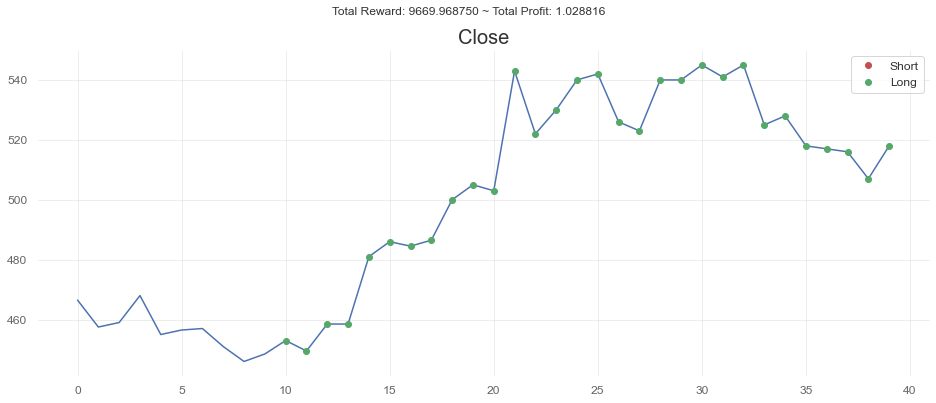

In [17]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


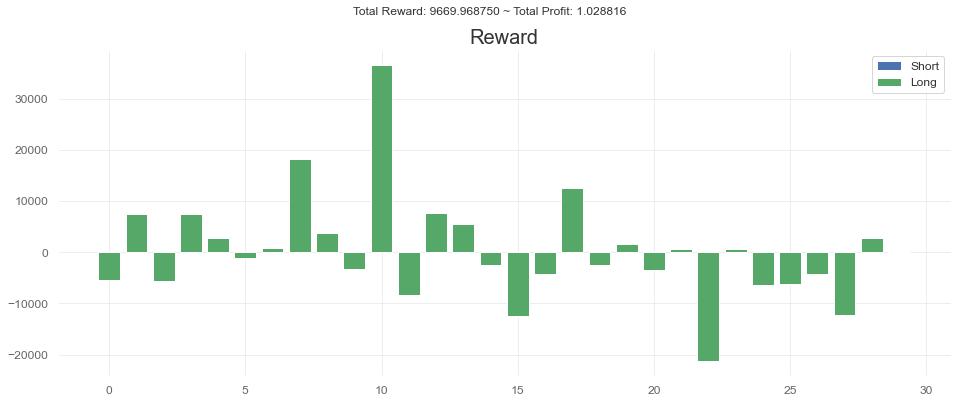

In [18]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


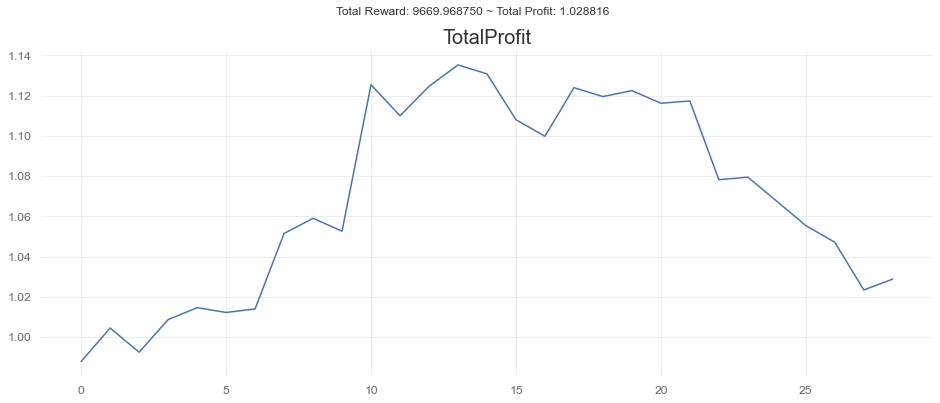

In [19]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)